# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 1

In [2]:
cluster = '6'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 249
Num noneffect sequences: 249


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
192   chr3   49053262   49053263    rs7373790      T         C   T    A,C   
122  chr19   44644418   44644419   rs10426401      T         G   T      G   
111  chr17   75088242   75088243   rs55827552      A         G   A      G   
169   chr2  127128581  127128582   rs13025717      T         C   C      T   
220   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
160  chr19   45326123   45326124     rs344792      A         G   G      A   
58   chr17    5235008    5235009   rs75511804      T         C   C      T   
222   chr5  102971887  102971888    rs6881225      T         C   T      C   
13   chr11   47731222   47731223   rs17788930      A         G   A      G   
53   chr17    4901871    4901872   rs79436576      T         C   C      T   
101  chr17   58332679   58332680    rs2526377      G         A   A      G   
190   chr3   49007333   49007334    rs6781790      T         C   C      T   
82   chr17   45894775   45894776   rs11575896      G         A   G      A   
83   chr17   45896285   45896286   rs62056780      T         C   C    G,T   
78   chr17   45852871   45852872   rs79589869      C         A   C      A   
6    chr10   15515276   15515277     rs896434      T         G   T      G   
80   chr17   45894418   45894419   rs11575895      G         A   A      G   
230   chr6   27762683   27762684    rs7759217      G         A   A      G   
62   chr17   45639518   45639519     rs413778      A         G   A      G   
117  chr19   44577120   44577121   rs55848260      A         G   A      G   
91   chr17   46051886   46051887   rs17575423      T         C   T      C   
187   chr3   48740593   48740594    rs6442130      G         A   A      G   
3     chr1  232528864  232528865   rs10797576      T         C   C      T   
201   chr3  151391922  151391923   rs73159908      G         A   A      G   
184  chr20   56412159   56412160   rs17462136      C         G   G      C   
52   chr17    4889756    4889757    rs2277681      T         C   C    G,T   
229   chr6   27754284   27754285    rs4713121      T         C   T      C   
114  chr18   51198353   51198354    rs3819118      T         C   C  A,G,T   
143  chr19   44913033   44913034   rs59325138      T         C   C    G,T   
113  chr18   51197068   51197069    rs4396619      T         C   C      T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
67   chr17   45704411   45704412   rs17762361      A         G   A      G   
148  chr19   44955208   44955209  rs143674704      A         G   A      G   
25   chr12   41040085   41040086   rs12314872      T         A   A      T   
167   chr2  127107523  127107524   rs13032148      A         G   G      A   
54   chr17    4902093    4902094   rs72835059      A         G   G      A   
40   chr16   31002857   31002858    rs9926533      T         C   C      T   
205   chr4     973656     973657   rs13137144      G         A   G    A,C   
106  chr17   63460786   63460787  rs138190086      A         G   G      A   
129  chr19   44800803   44800804   rs12327715      A         G   G      A   
95   chr17   46192597   46192598   rs11079733      T         A   T      A   
244   chr8   22623005   22623006   rs11780207      G         A   G      A   
225   chr5  103120599  103120600      rs26524      G         A   A      G   
56   chr17    4909107    4909108   rs16954243      A         T   A      T   
203   chr3  161372827  161372828    rs2054710      T         C   C    G,T   
168   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
28   chr14   67515536   67515537    rs7154258      T         G   G      T   
43   chr16   31074148   31074149    rs2303222      T         C   T    A,C   
1     chr1  171742011  171742012   rs12119232      C         A   A      C   
241   chr8   16859416   16859417    rs7001099      T         G   T      G   
214   chr4   89753299   89753300    rs3756054      T         C   T      C   
79 

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs7373790   ||    chr3 : 49053262 - 49053263   ||    Locus: 192   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.49E-03
Nalls_23andMe 		  2.49E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.064   ||   Center / 200bp : 0.1444
Noneffect Sequence : CGAGGCAGGCGGATCACGAG


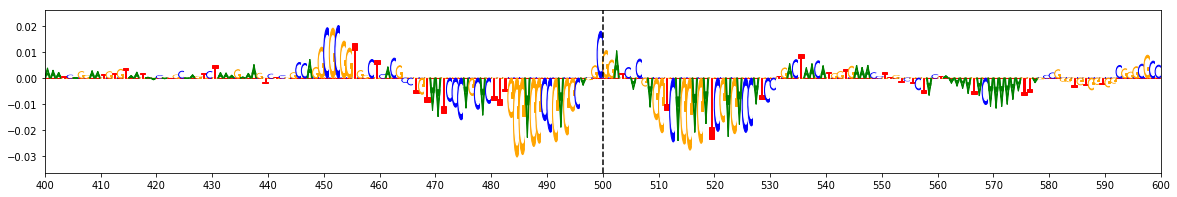

Effect Allele : T   ||   Explain Score : 0.0015   ||   Center / 200bp : 0.0041
Effect Sequence : CGAGGCAGGTGGATCACGAG


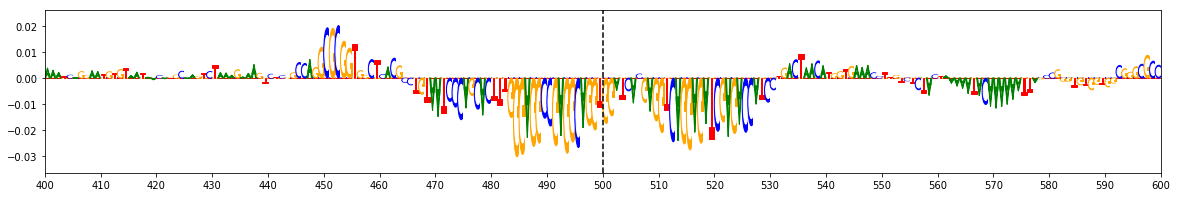

Allele Ratio : 0.0241   ||   Allele Difference : -0.2249  ||  ISM Score : -0.3573  ||  deltaSVM Score : -2.0514


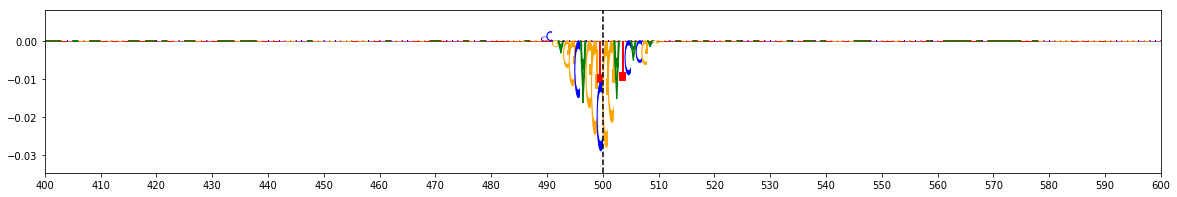


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 122   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.5209   ||   Center / 200bp : 0.6046
Noneffect Sequence : CAACACGGGGCGGGCACAAG


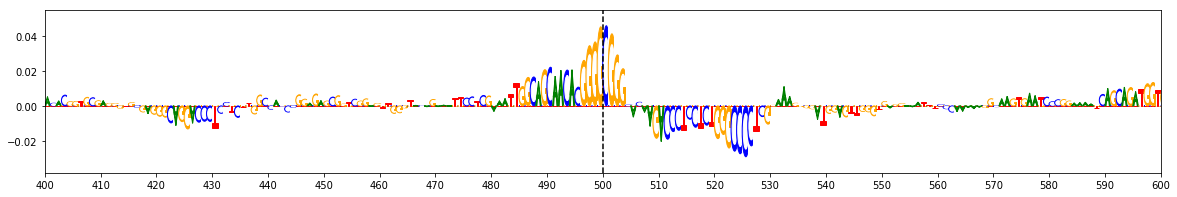

Effect Allele : T   ||   Explain Score : 0.2011   ||   Center / 200bp : 0.3707
Effect Sequence : CAACACGGGTCGGGCACAAG


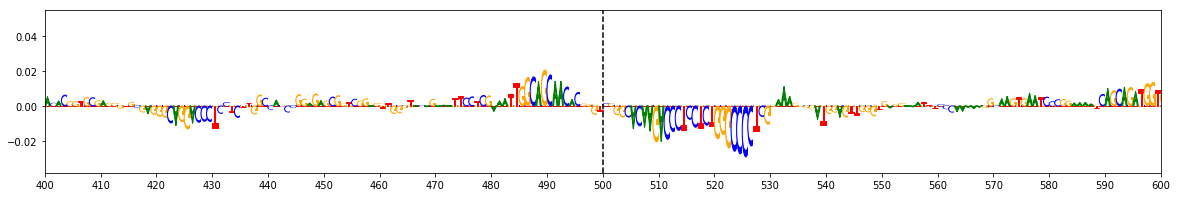

Allele Ratio : 0.3861   ||   Allele Difference : -0.3772  ||  ISM Score : -0.6013  ||  deltaSVM Score : -3.4432


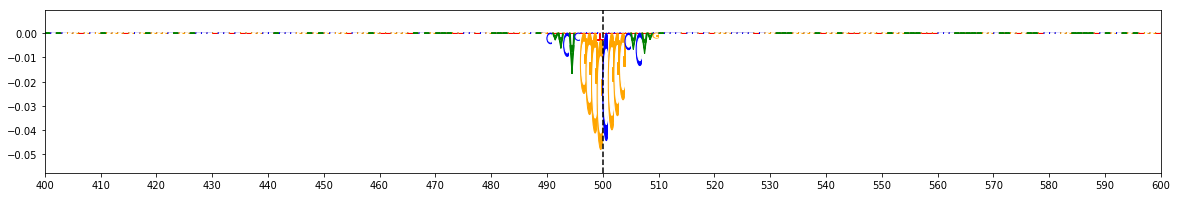


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55827552   ||    chr17 : 75088242 - 75088243   ||    Locus: 111   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  1.87E-03
Alzheimers_Lambert_2013 	  8.30E-03

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3274   ||   Center / 200bp : 0.4287
Noneffect Sequence : CGCAAGCCCGAGGGCGCTCG


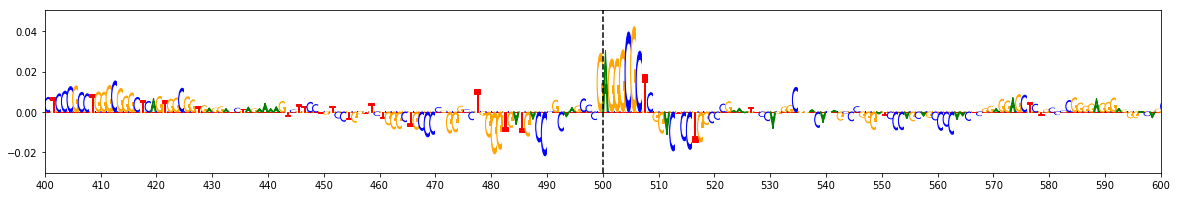

Effect Allele : A   ||   Explain Score : 0.09   ||   Center / 200bp : 0.1707
Effect Sequence : CGCAAGCCCAAGGGCGCTCG


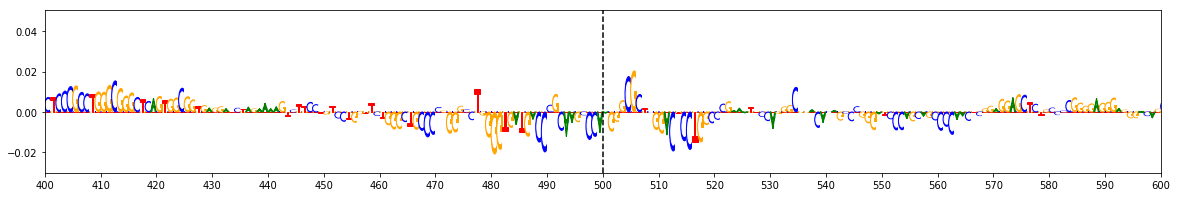

Allele Ratio : 0.2749   ||   Allele Difference : -0.3075  ||  ISM Score : -0.4881  ||  deltaSVM Score : -2.8078


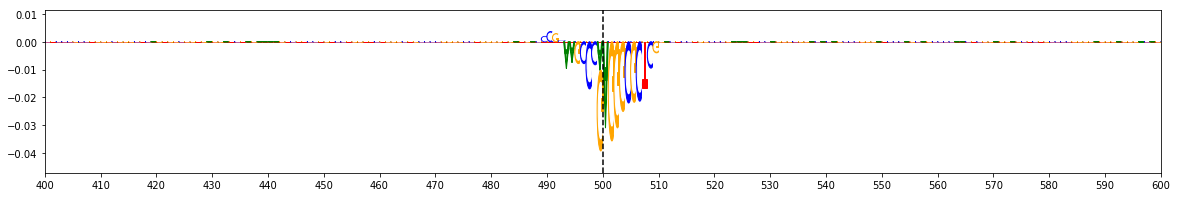


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 169   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.1289   ||   Center / 200bp : 0.6373
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


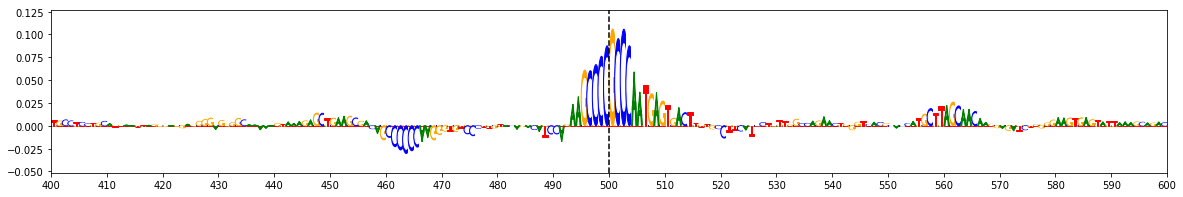

Effect Allele : T   ||   Explain Score : 0.4982   ||   Center / 200bp : 0.4369
Effect Sequence : CAGAAGCCCTGCCCAATGAG


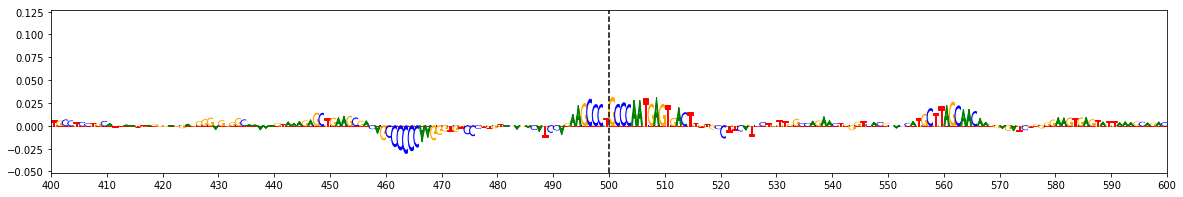

Allele Ratio : 0.4413   ||   Allele Difference : -0.6167  ||  ISM Score : -0.9615  ||  deltaSVM Score : -5.4445


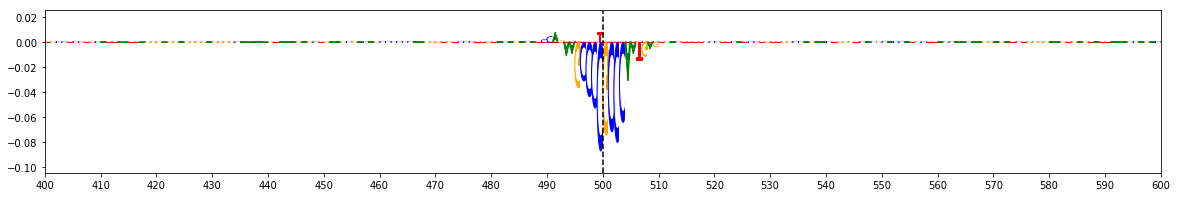


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 220   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.6774   ||   Center / 200bp : 0.5813
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


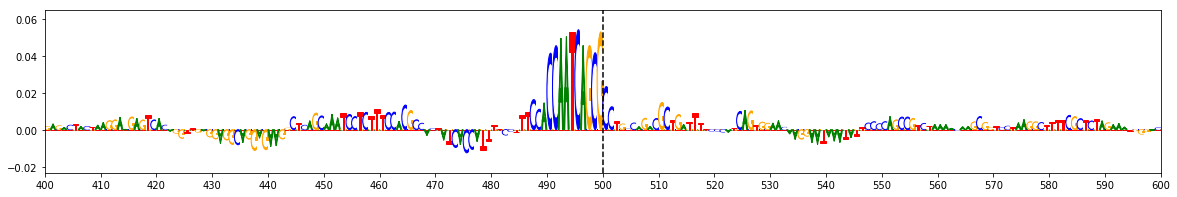

Effect Allele : NAN   ||   Explain Score : 0.3324   ||   Center / 200bp : 0.4033
Effect Sequence : CCAATCAGCCCCTGCCAGAC


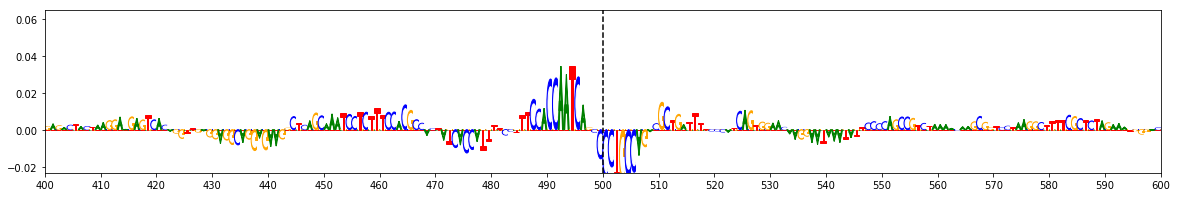

Allele Ratio : 0.4906   ||   Allele Difference : -0.5402  ||  ISM Score : -0.8274  ||  deltaSVM Score : -4.9144


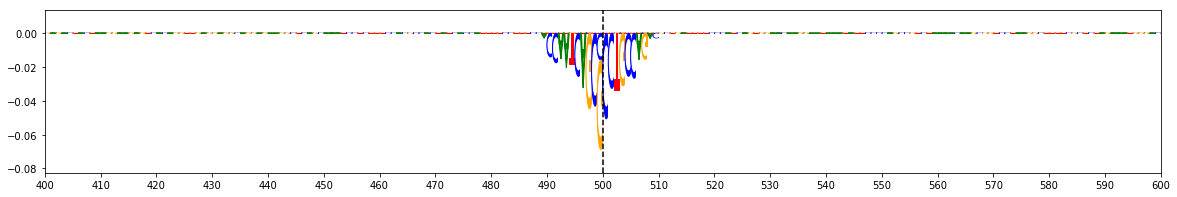


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344792   ||    chr19 : 45326123 - 45326124   ||    Locus: 160   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.52E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.2011   ||   Center / 200bp : 0.4529
Noneffect Sequence : CTAGTCTCAGACTCCTACCT


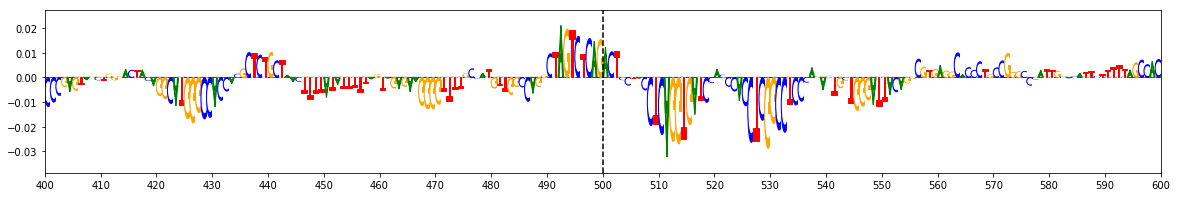

Effect Allele : A   ||   Explain Score : 0.0846   ||   Center / 200bp : 0.2576
Effect Sequence : CTAGTCTCAAACTCCTACCT


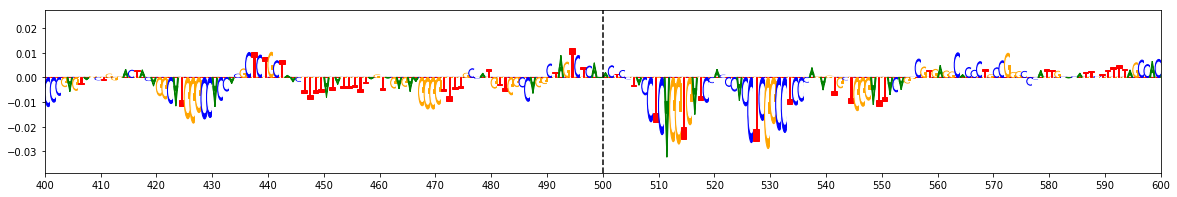

Allele Ratio : 0.4205   ||   Allele Difference : -0.1224  ||  ISM Score : -0.194  ||  deltaSVM Score : -1.1014


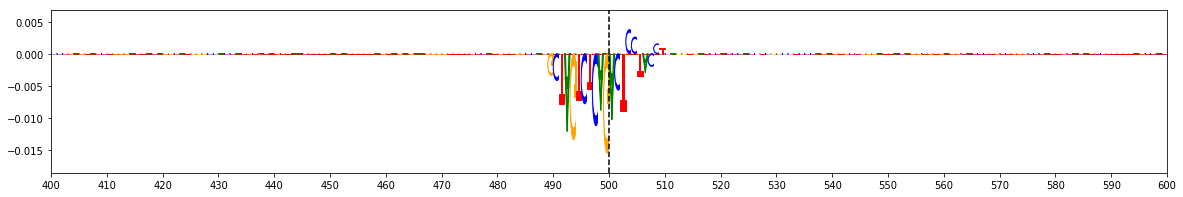


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs75511804   ||    chr17 : 5235008 - 5235009   ||    Locus: 58   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.68E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.2584   ||   Center / 200bp : 0.5092
Noneffect Sequence : TGTCGCTCCCGCAAGGCCTA


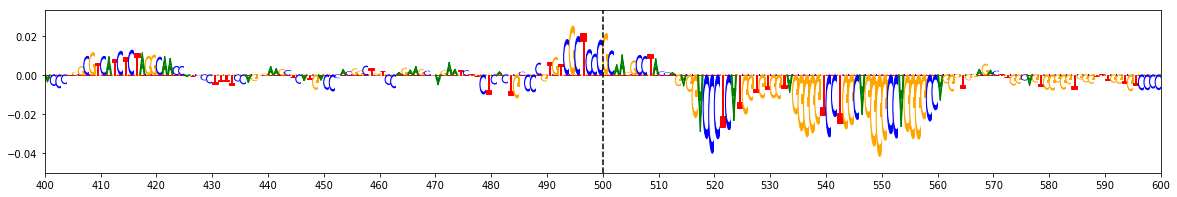

Effect Allele : T   ||   Explain Score : 0.1337   ||   Center / 200bp : 0.3499
Effect Sequence : TGTCGCTCCTGCAAGGCCTA


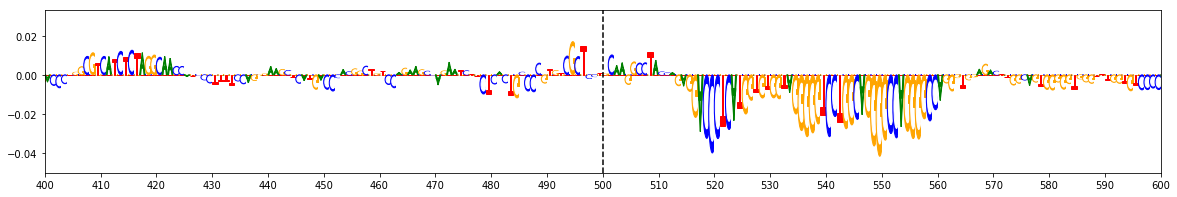

Allele Ratio : 0.5173   ||   Allele Difference : -0.1326  ||  ISM Score : -0.2103  ||  deltaSVM Score : -1.2221


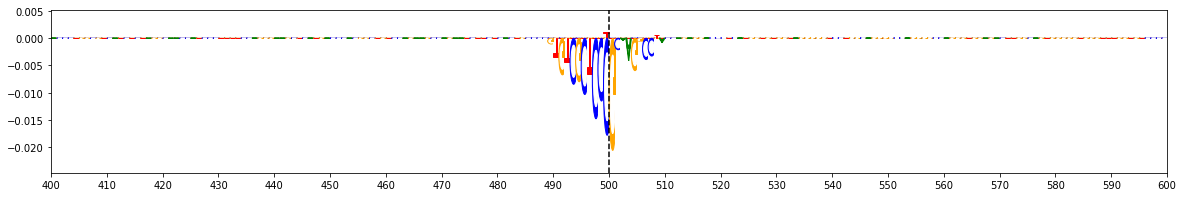


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 222   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.7788   ||   Center / 200bp : 0.7945
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


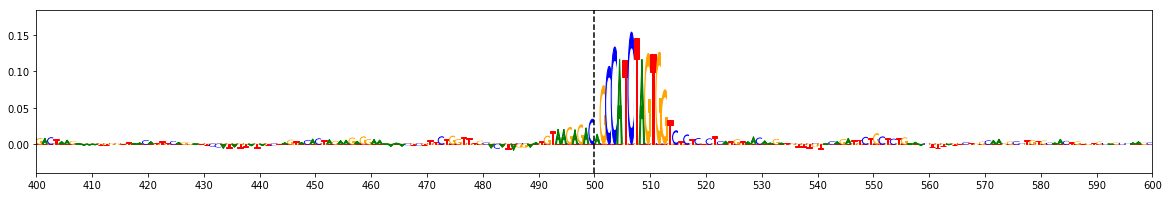

Effect Allele : T   ||   Explain Score : 1.4502   ||   Center / 200bp : 0.7593
Effect Sequence : TGTAAGAGATAGCCATCTAG


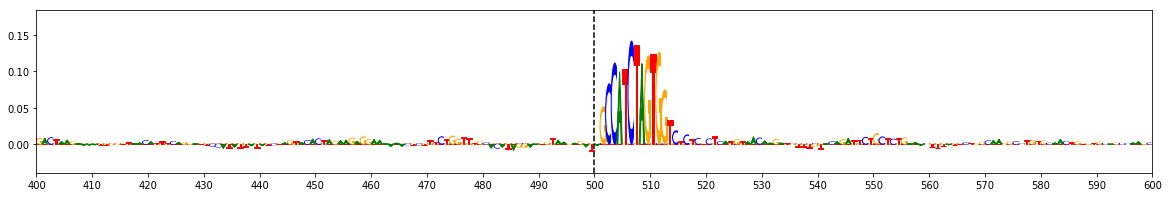

Allele Ratio : 0.8152   ||   Allele Difference : -0.3454  ||  ISM Score : -0.5412  ||  deltaSVM Score : -3.1108


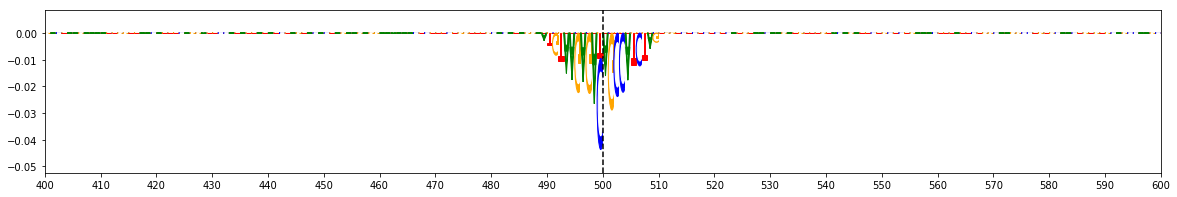


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17788930   ||    chr11 : 47731222 - 47731223   ||    Locus: 13   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  2.41E-08

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3238   ||   Center / 200bp : 0.5514
Noneffect Sequence : CCAACCATAGTAACTCATGC


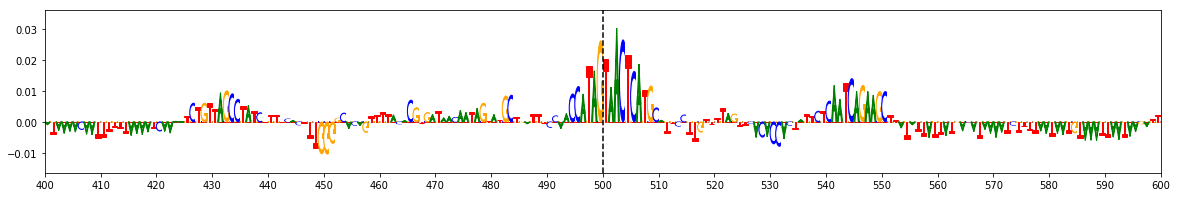

Effect Allele : A   ||   Explain Score : 0.1899   ||   Center / 200bp : 0.4188
Effect Sequence : CCAACCATAATAACTCATGC


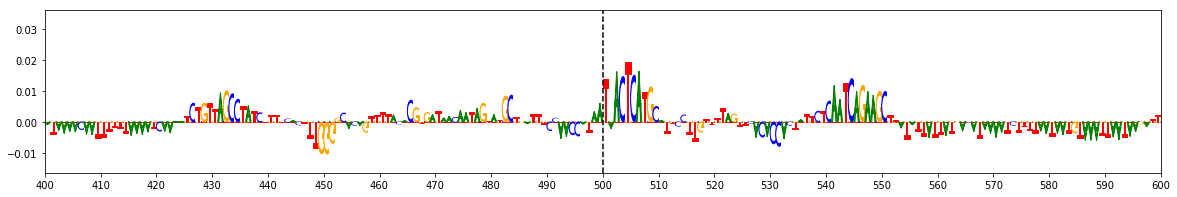

Allele Ratio : 0.5866   ||   Allele Difference : -0.1577  ||  ISM Score : -0.2477  ||  deltaSVM Score : -1.4183


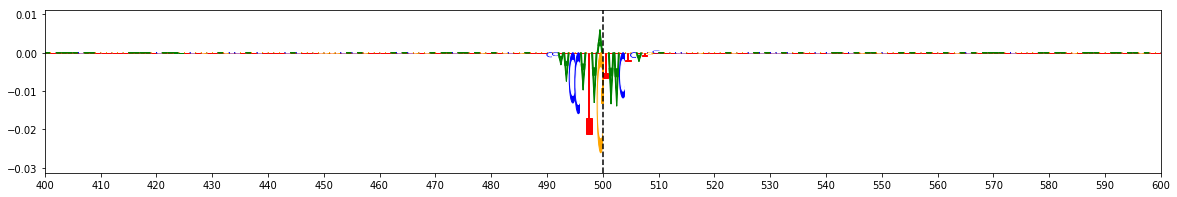


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 53   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  3.06E-04
Alzheimers_Lambert_2013 	  4.79E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.7095   ||   Center / 200bp : 0.5089
Noneffect Sequence : CGGTTGGCCCCGCCCCATAA


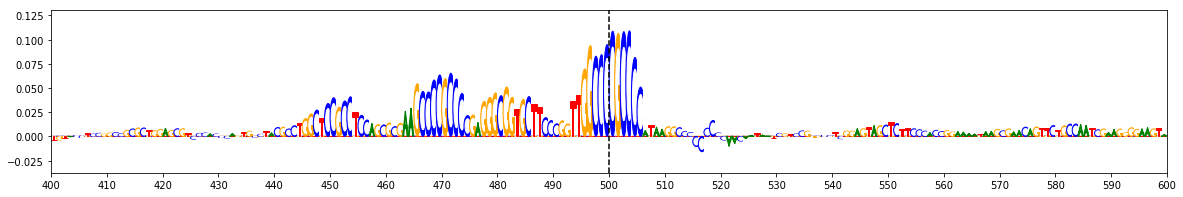

Effect Allele : T   ||   Explain Score : 0.9327   ||   Center / 200bp : 0.3583
Effect Sequence : CGGTTGGCCTCGCCCCATAA


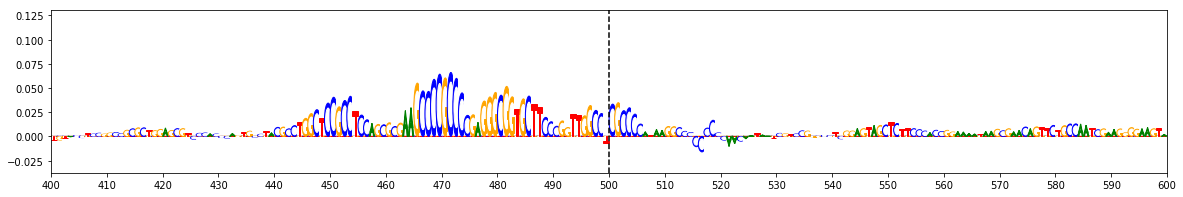

Allele Ratio : 0.5456   ||   Allele Difference : -0.7841  ||  ISM Score : -1.2255  ||  deltaSVM Score : -7.2533


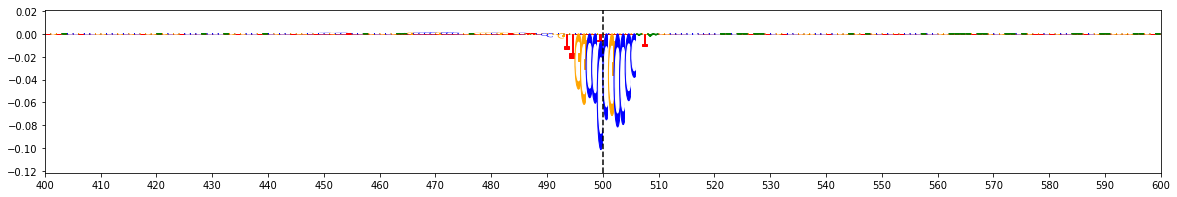


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2526377   ||    chr17 : 58332679 - 58332680   ||    Locus: 101   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.13E-07
Alzheimers_Kunkle_2019 		  1.95E-06
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.617   ||   Center / 200bp : 0.5431
Noneffect Sequence : GGAAACAGAAGGGGGTGGGC


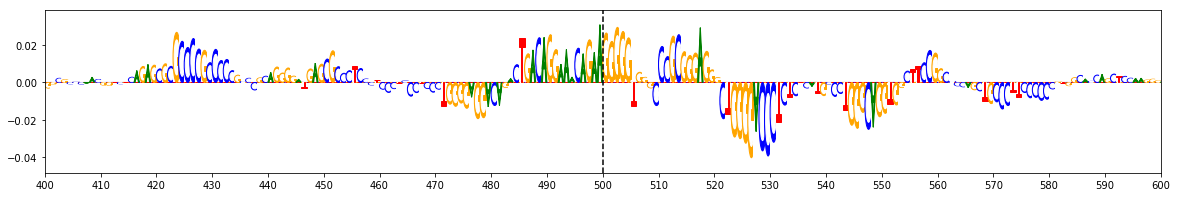

Effect Allele : G   ||   Explain Score : 0.369   ||   Center / 200bp : 0.4159
Effect Sequence : GGAAACAGAGGGGGGTGGGC


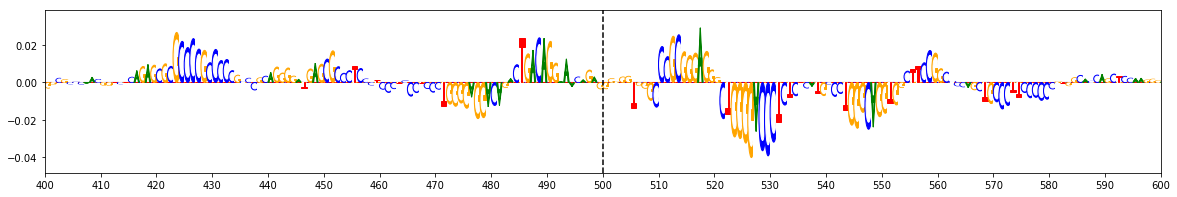

Allele Ratio : 0.598   ||   Allele Difference : -0.2699  ||  ISM Score : -0.4498  ||  deltaSVM Score : -2.5794


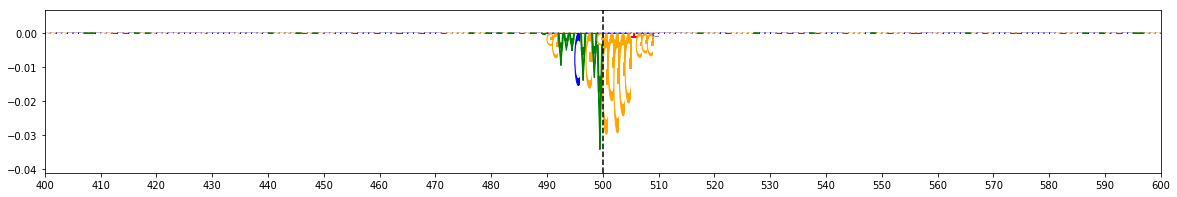


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 190   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9246   ||   Center / 200bp : 0.4692
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


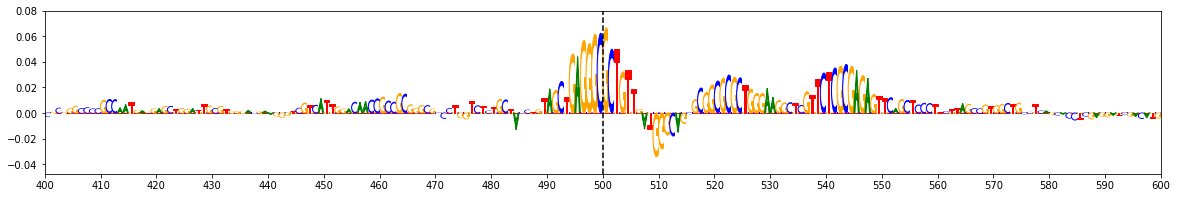

Effect Allele : T   ||   Explain Score : 0.4833   ||   Center / 200bp : 0.3158
Effect Sequence : AGCTGAGGGTGCTGTTGATG


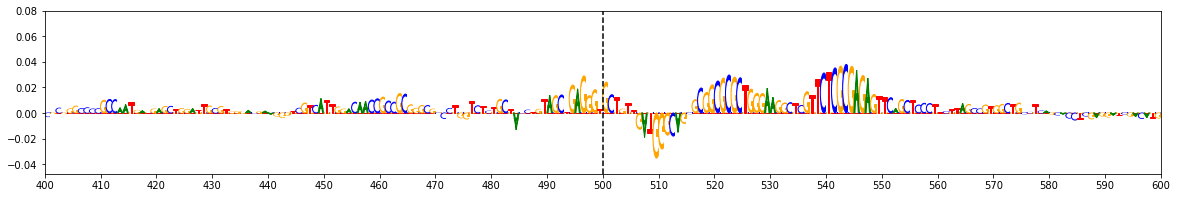

Allele Ratio : 0.5226   ||   Allele Difference : -0.4651  ||  ISM Score : -0.7327  ||  deltaSVM Score : -4.2278


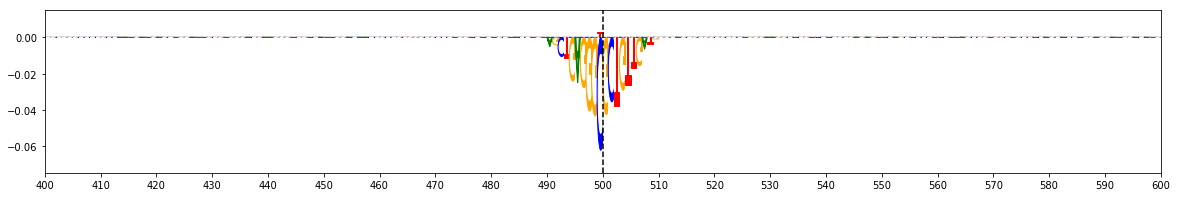


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 82   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.3504   ||   Center / 200bp : 0.5928
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


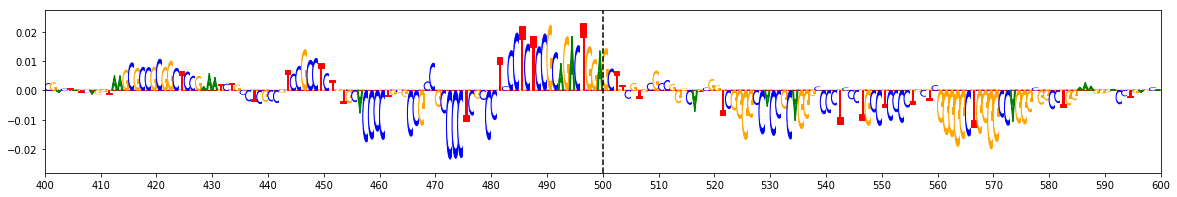

Effect Allele : G   ||   Explain Score : 0.2369   ||   Center / 200bp : 0.4963
Effect Sequence : GCAGACTGGGGCTTCGTGCG


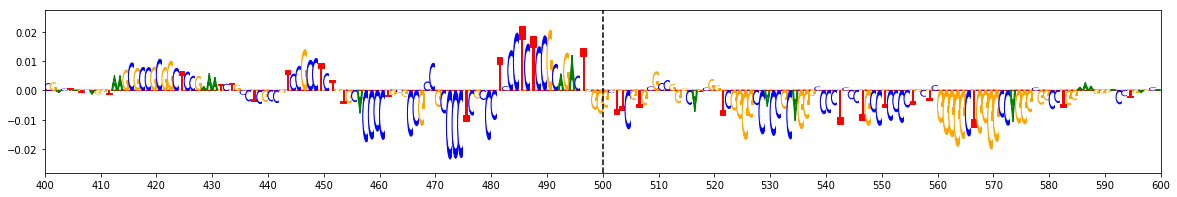

Allele Ratio : 0.6762   ||   Allele Difference : -0.1709  ||  ISM Score : -0.2746  ||  deltaSVM Score : -1.5767


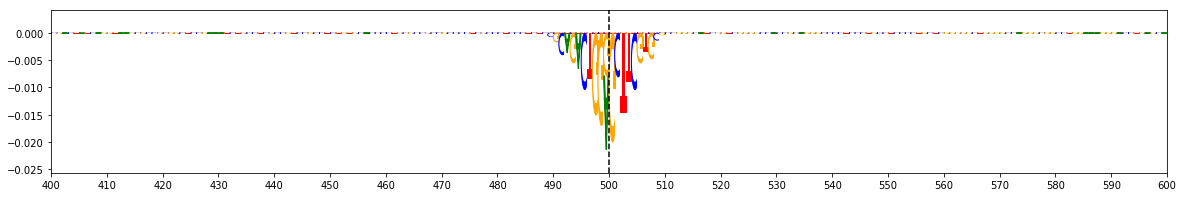


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056780   ||    chr17 : 45896285 - 45896286   ||    Locus: 83   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8939   ||   Center / 200bp : 0.5859
Noneffect Sequence : GAGGGATCTCGCCCCTCCCT


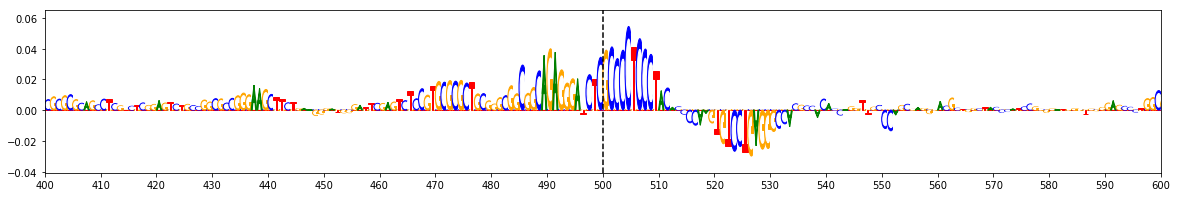

Effect Allele : T   ||   Explain Score : 0.6173   ||   Center / 200bp : 0.4941
Effect Sequence : GAGGGATCTTGCCCCTCCCT


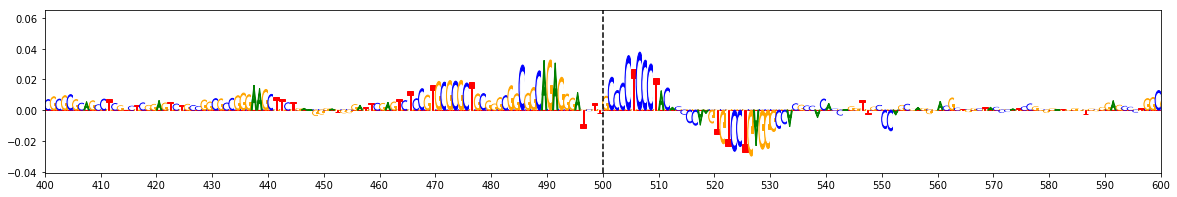

Allele Ratio : 0.6906   ||   Allele Difference : -0.2877  ||  ISM Score : -0.4536  ||  deltaSVM Score : -2.6172


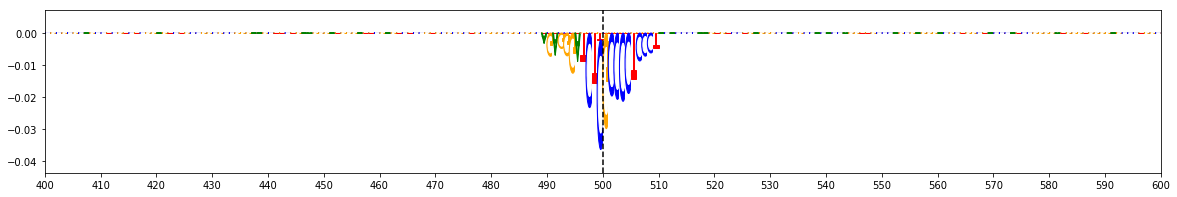


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 78   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.0246   ||   Center / 200bp : 0.8236
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


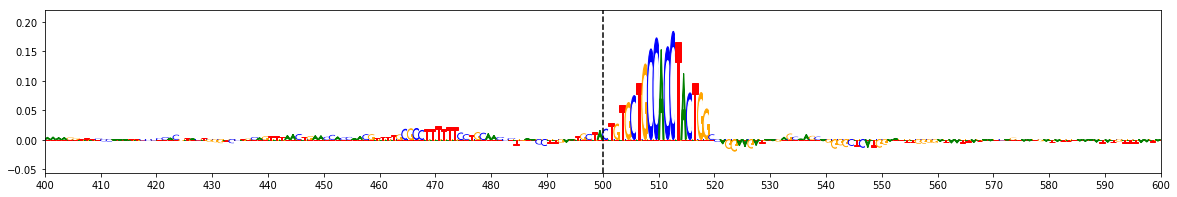

Effect Allele : C   ||   Explain Score : 2.0076   ||   Center / 200bp : 0.8223
Effect Sequence : TTGAATGCTCCTGTGCTGCC


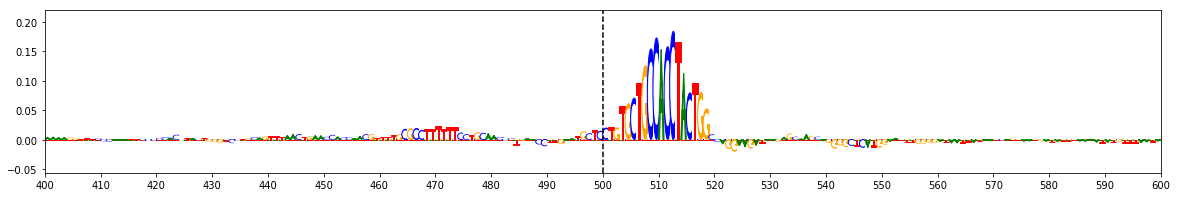

Allele Ratio : 0.9916   ||   Allele Difference : -0.0128  ||  ISM Score : -0.0202  ||  deltaSVM Score : -0.1167


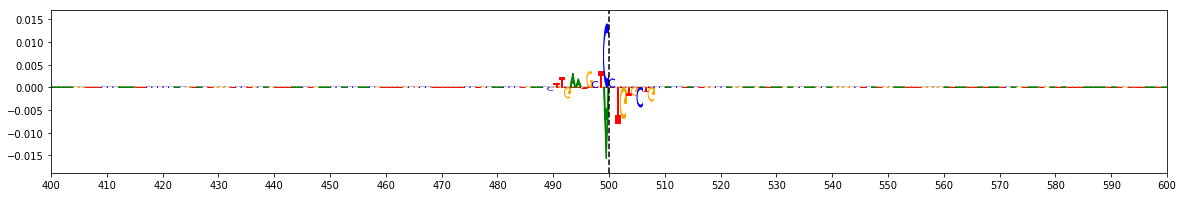


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs896434   ||    chr10 : 15515276 - 15515277   ||    Locus: 6   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  4.87E-04
Nalls_23andMe 		  4.87E-04

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.4805   ||   Center / 200bp : 0.6123
Noneffect Sequence : CAGTGCTCAGCCGTAGTCAG


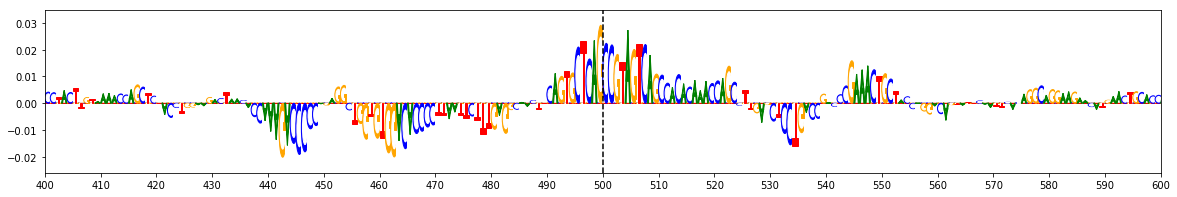

Effect Allele : T   ||   Explain Score : 0.3609   ||   Center / 200bp : 0.5425
Effect Sequence : CAGTGCTCATCCGTAGTCAG


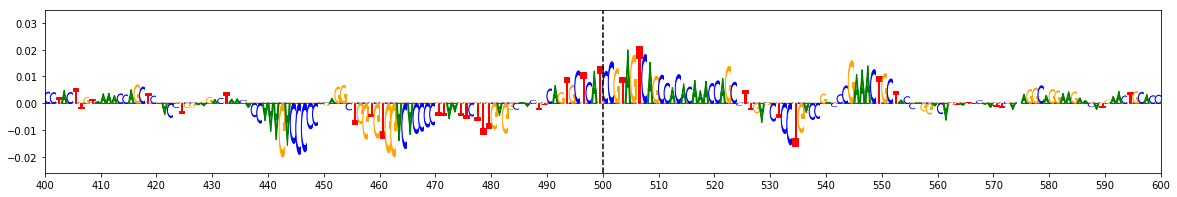

Allele Ratio : 0.751   ||   Allele Difference : -0.12  ||  ISM Score : -0.1868  ||  deltaSVM Score : -1.0839


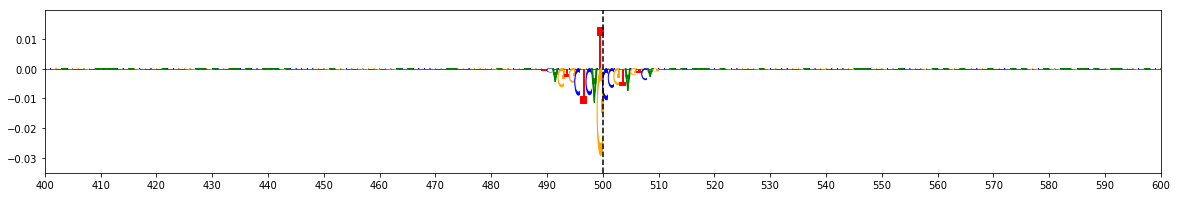


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 80   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.0434   ||   Center / 200bp : 0.7218
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


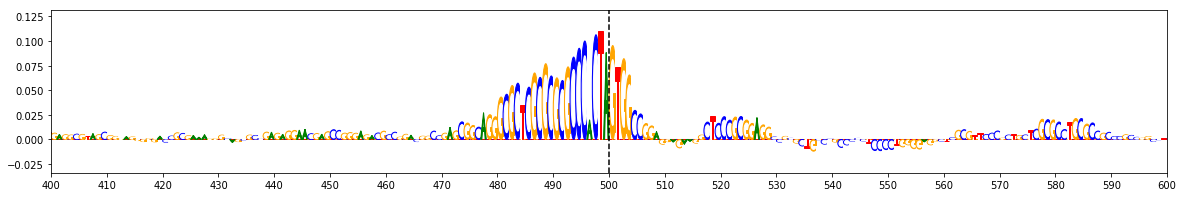

Effect Allele : G   ||   Explain Score : 1.8546   ||   Center / 200bp : 0.7
Effect Sequence : GCGCCCACTGGTGGCCGGAG


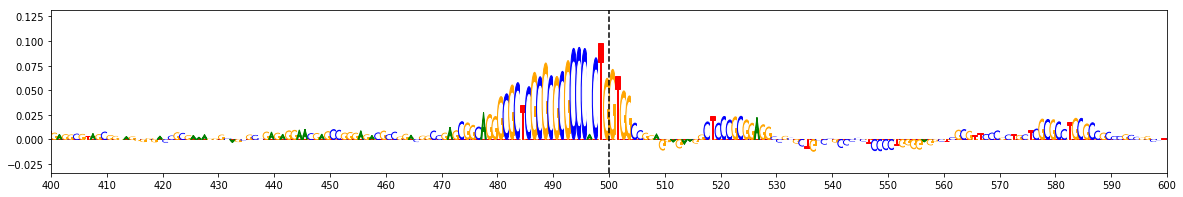

Allele Ratio : 0.9076   ||   Allele Difference : -0.195  ||  ISM Score : -0.2723  ||  deltaSVM Score : -1.9905


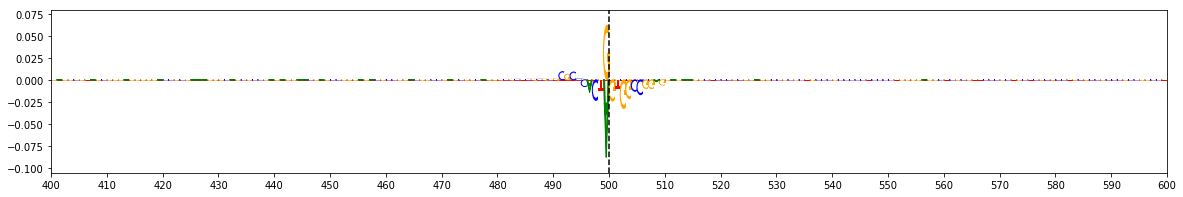


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7759217   ||    chr6 : 27762683 - 27762684   ||    Locus: 230   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  2.64E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.5106   ||   Center / 200bp : 0.6409
Noneffect Sequence : ACAGCGCAGATAGGGTTGTT


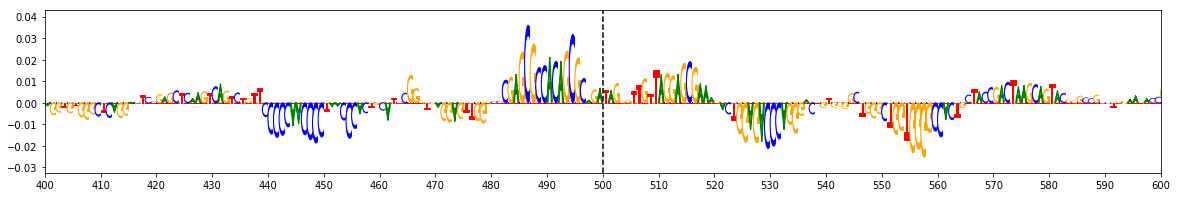

Effect Allele : G   ||   Explain Score : 0.4248   ||   Center / 200bp : 0.5976
Effect Sequence : ACAGCGCAGGTAGGGTTGTT


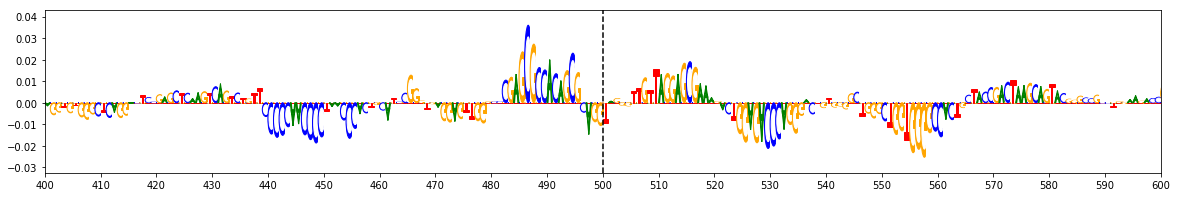

Allele Ratio : 0.8319   ||   Allele Difference : -0.1363  ||  ISM Score : -0.2131  ||  deltaSVM Score : -1.232


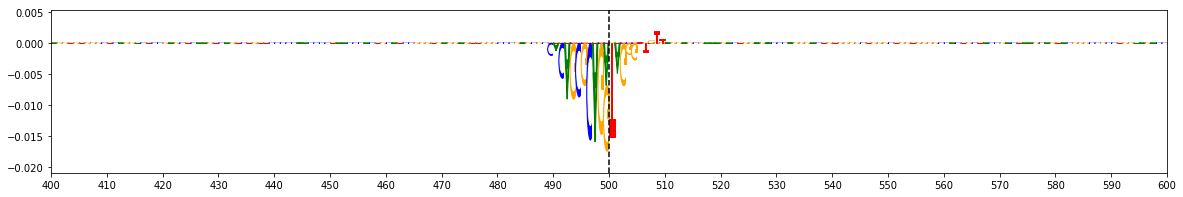


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs413778   ||    chr17 : 45639518 - 45639519   ||    Locus: 62   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.96E-22
Parkinsons_Pankratz_2012 	  2.17E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.204   ||   Center / 200bp : 0.5873
Noneffect Sequence : GGTGAGTCAGAGTAAGTATA


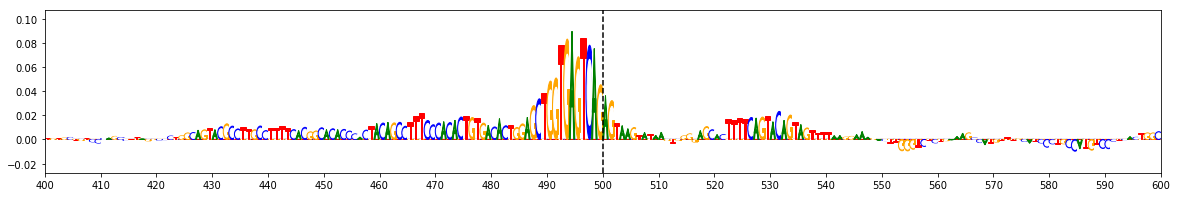

Effect Allele : A   ||   Explain Score : 0.9202   ||   Center / 200bp : 0.5209
Effect Sequence : GGTGAGTCAAAGTAAGTATA


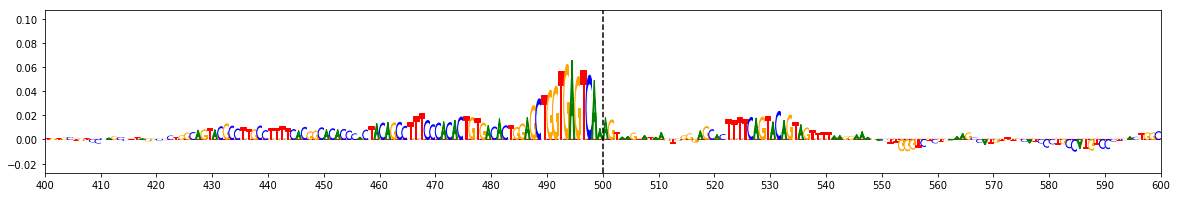

Allele Ratio : 0.7643   ||   Allele Difference : -0.2838  ||  ISM Score : -0.442  ||  deltaSVM Score : -2.5813


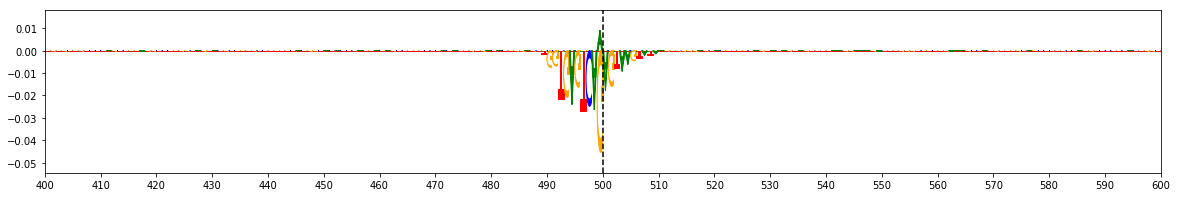


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55848260   ||    chr19 : 44577120 - 44577121   ||    Locus: 117   ||    IDR Peak: False

GWAS:
Alzheimers_Lambert_2013 	  1.68E-06
Alzheimers_Jansen_2018 		  2.72E-13
Alzheimers_Kunkle_2019 		  4.40E-11

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.2591   ||   Center / 200bp : 0.6459
Noneffect Sequence : CCTCCTAGAGCCTGCAGAGG


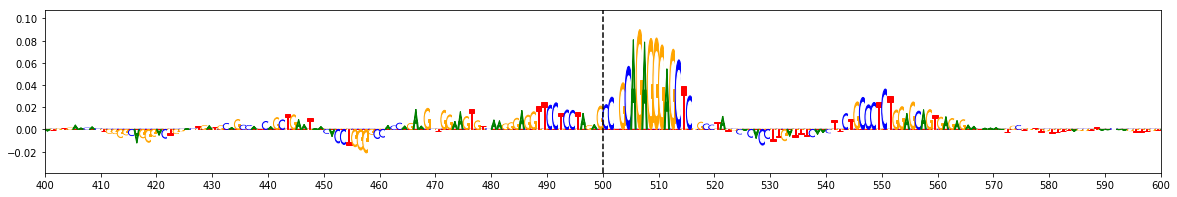

Effect Allele : A   ||   Explain Score : 1.0735   ||   Center / 200bp : 0.6086
Effect Sequence : CCTCCTAGAACCTGCAGAGG


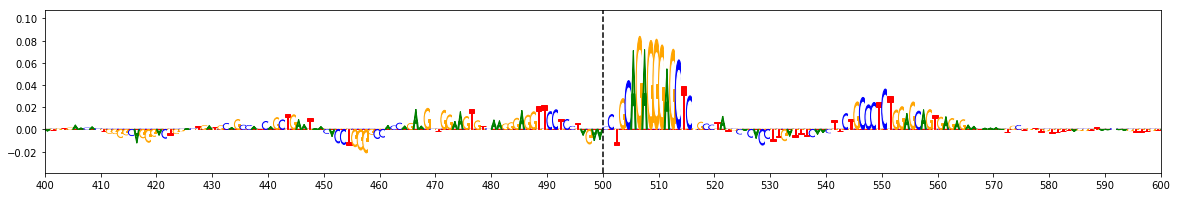

Allele Ratio : 0.8526   ||   Allele Difference : -0.2382  ||  ISM Score : -0.3734  ||  deltaSVM Score : -2.1655


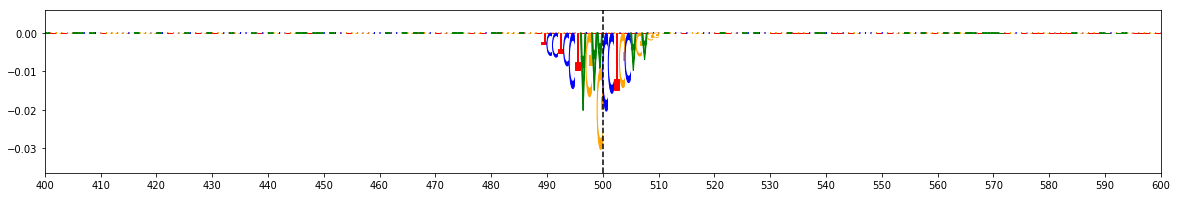


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
77   chr17   45852666   45852667   rs62054825      G         A   G      A   
154  chr19   45039212   45039213   rs34034621      T         C   C      T   
90   chr17   46038519   46038520   rs12150090      T         C   C    G,T   
208   chr4     987143     987144   rs10902762      G         A   G      A   
66   chr17   45704380   45704381    rs1724425      T         C   C      T   
242   chr8   22599691   22599692     rs755934      T         G   T      G   
98   chr17   46267696   46267697    rs2732651      T         C   C      T   
92   chr17   46130565   46130566   rs79301522      G         A   A      G   
120  chr19   44644039   44644040   rs11540084      T         G   G      T   
179   chr2  134718389  134718390   rs62171393      G         C   C      G   
116  chr19   18428933   18428934   rs34746918      T         C   C      T   
181   chr2  134719288  134719289   rs62171396      T         C   C      T   
59   chr17    5255418    5255419   rs61481506      C         T   T      C   
236   chr7   23205949   23205950     rs858295      G         A   A    C,G   
5    chr10   15515271   15515272     rs878320      G         C   G      C   
50   chr17    4842691    4842692   rs72835016      C         G   G      C   
14   chr11   86069405   86069406    rs3016327      T         C   T      C   
104  chr17   62065808   62065809    rs3826419      G         C   C      G   
183  chr20    6006303    6006304    rs6085343      G         A   G      A   
23   chr12   40224911   40224912  rs139549144      G         C   C  A,G,T   
164   chr2  127107344  127107345   rs76516995    NAN       NAN   C    A,G   
177   chr2  134707045  134707046   rs57891859      G         A   A      G   
27   chr14   67515152   67515153    rs2273596      T         C   T      C   
125  chr19   44723890   44723891  rs150820726      T         A   A      T   
60   chr17    5282069    5282070  rs113151753      G         C   C    G,T   
180   chr2  134719264  134719265   rs62171395      G         C   C      G   
198   chr3  151379602  151379603   rs17283010      G         A   G      A   
119  chr19   44643845   44643846  19_44643846      A         G   .      .   
86   chr17   45949123   45949124   rs77266933      C         A   A      C   
45   chr16   31106091   31106092    rs2032915      T         C   C      T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
47   chr16   31142824   31142825    rs1549299      G         A   G      A   
31   chr14   92466134   92466135    rs4904922      G         T   G    C,T   
238   chr7  100217623  100217624    rs1727138      T         C   T      C   
206   chr4     986675     986676    rs4690220      G         A   A      G   
4    chr10   15515115   15515116     rs878321      G         A   G      A   
155  chr19   45045876   45045877  rs112481437      A         G   G      A   
228   chr5  134600503  134600504  rs142547906      G         A   G      A   
115  chr19    1040046    1040047    rs3764642      A         G   G    A,C   
175   chr2  127135379  127135380   rs72838287      G         C   C      G   
61   chr17   45584384   45584385    rs2693359      T         A   T      A   
151  chr19   44969003   44969004   rs59136988      A         T   T      A   
215   chr4   89788589   89788590    rs3775439      G         A   G      A   
189   chr3   48998451   48998452    rs6414613      T         C   C      T   
209   chr4   18022407   18022408    rs1380295      G         C   C    A,G   
204   chr4     973550     973551  rs113075206      G         C   C      G   
196   chr3   52339932   52339933  rs149814394      G         A   G      A   
231   chr6   47477280   47477281    rs1004173      T         C   C      T   
202   chr3  161334004  161334005   rs11718905      G         A   G      A   
126  chr19   44784591   44784592    rs2927448      T         G   G      T   
55   chr17    4902141    4902142   rs72835061      A         C   C      A   
132

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 77   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.25E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.1866   ||  Center / 200bp: 0.8711
Effect Sequence: TGAGCTCCCGGAAGTGGAGT


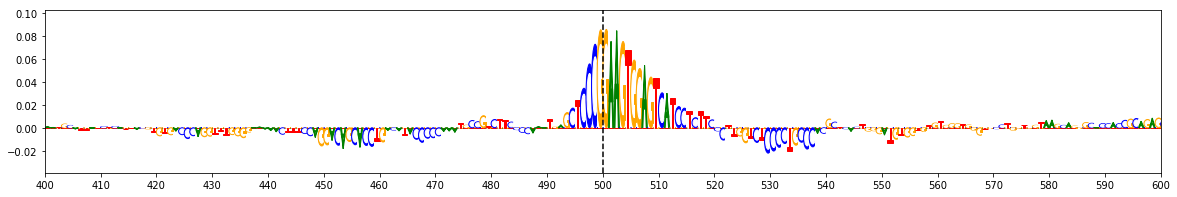

Noneffect Allele: A   ||  Explain Score: 0.4682   ||  Center / 200bp: 0.7271
Noneffect Sequence: TGAGCTCCCAGAAGTGGAGT


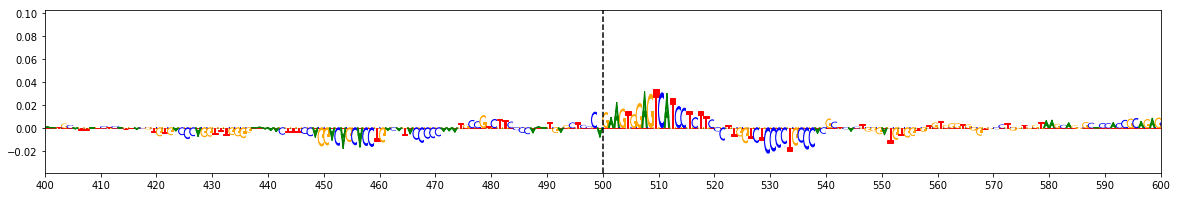

Allele Ratio : 2.5344   ||   Allele Difference : 0.7355  ||  ISM Score : 1.1513  ||  deltaSVM Score : 6.5979


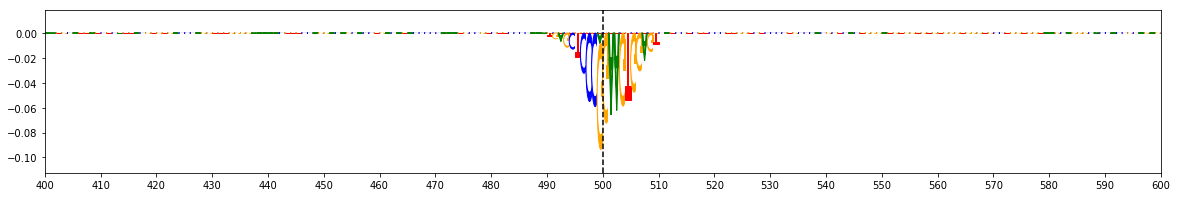


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 154   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4514   ||  Center / 200bp: 0.62
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


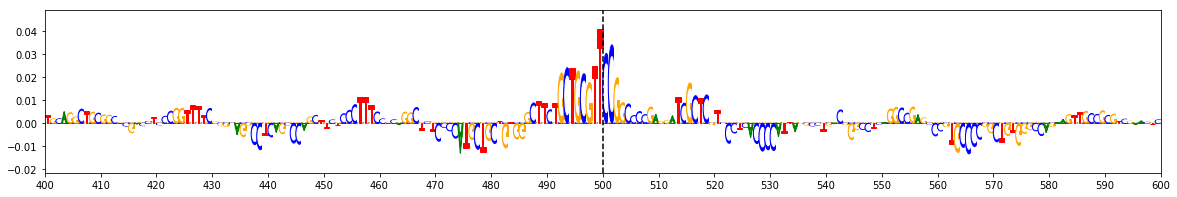

Noneffect Allele: C   ||  Explain Score: 0.1578   ||  Center / 200bp: 0.3636
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


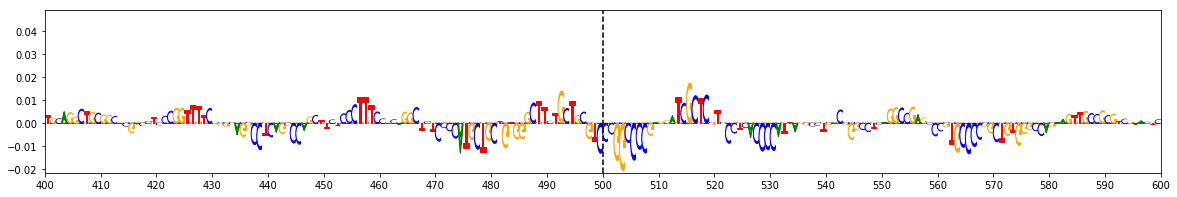

Allele Ratio : 2.8606   ||   Allele Difference : 0.4241  ||  ISM Score : 0.6717  ||  deltaSVM Score : 3.8793


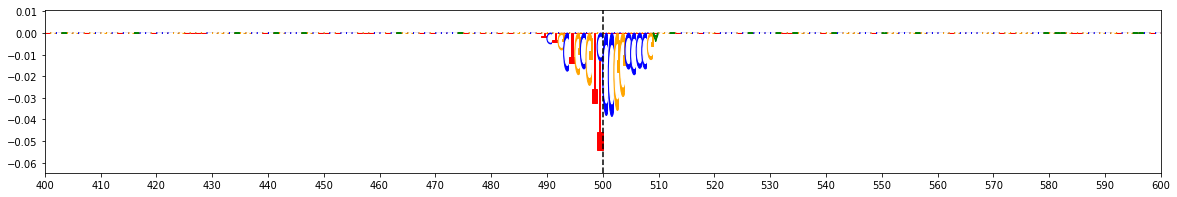


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12150090   ||    chr17 : 46038519 - 46038520   ||    Locus: 90   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22
Parkinsons_Pankratz_2012 	  4.06E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5217   ||  Center / 200bp: 0.4422
Effect Sequence: TCCGGCCAATCCCACACAGG


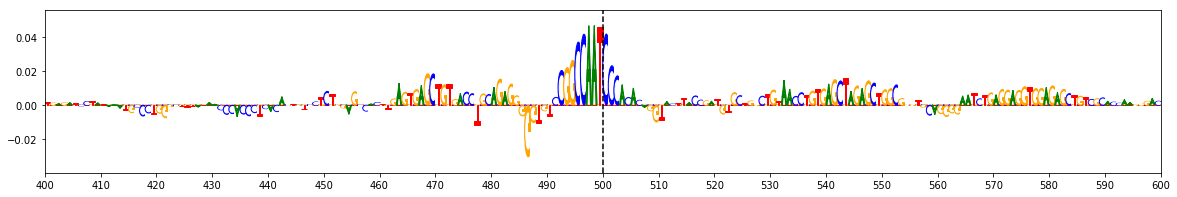

Noneffect Allele: C   ||  Explain Score: 0.1573   ||  Center / 200bp: 0.1933
Noneffect Sequence: TCCGGCCAACCCCACACAGG


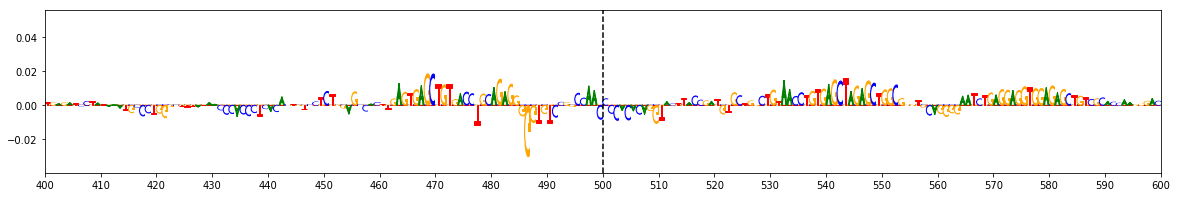

Allele Ratio : 3.316   ||   Allele Difference : 0.4246  ||  ISM Score : 0.6635  ||  deltaSVM Score : 3.8445


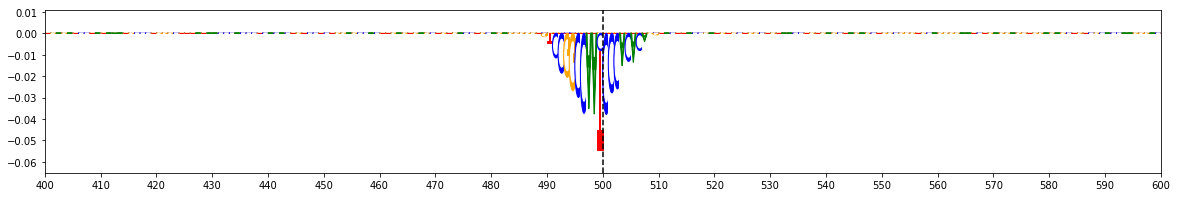


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 208   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.2106   ||  Center / 200bp: 0.3289
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


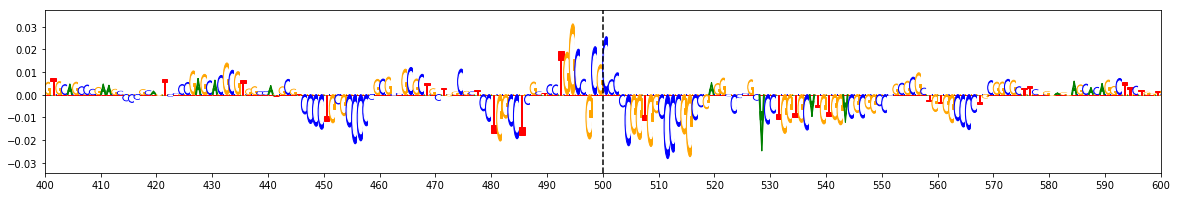

Noneffect Allele: A   ||  Explain Score: 0.0559   ||  Center / 200bp: 0.1136
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


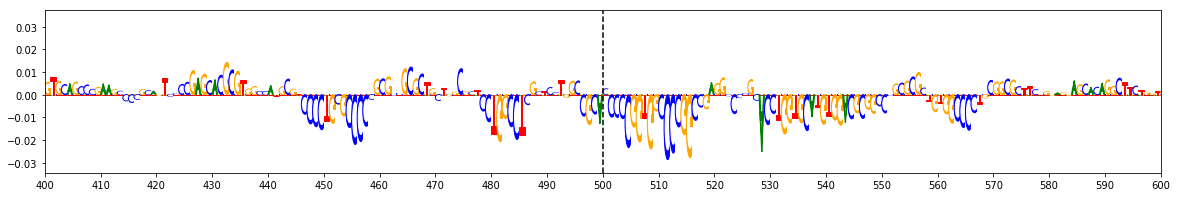

Allele Ratio : 3.766   ||   Allele Difference : 0.2085  ||  ISM Score : 0.3431  ||  deltaSVM Score : 2.0126


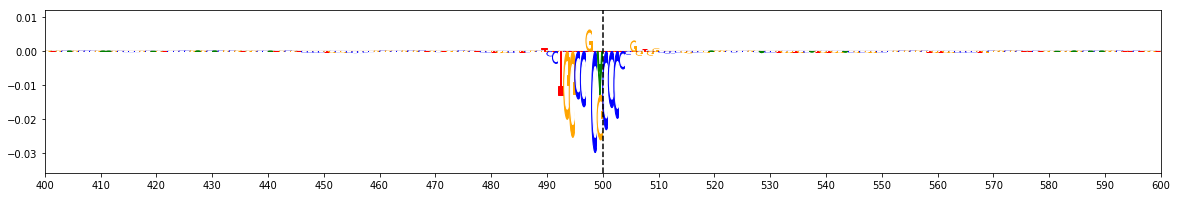


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1724425   ||    chr17 : 45704380 - 45704381   ||    Locus: 66   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  5.70E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3055   ||  Center / 200bp: 0.6226
Effect Sequence: AGTCGATTTTCACTCTTCCA


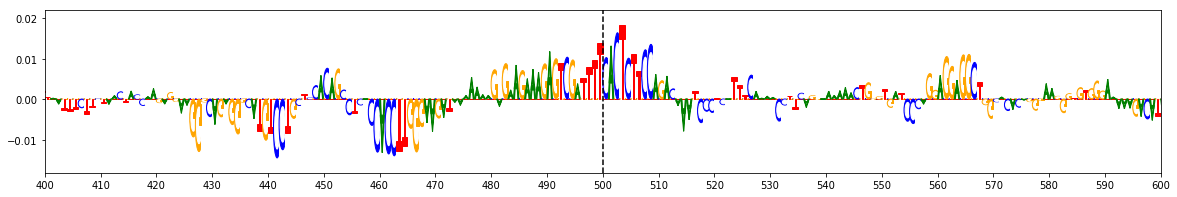

Noneffect Allele: C   ||  Explain Score: 0.2181   ||  Center / 200bp: 0.5412
Noneffect Sequence: AGTCGATTTCCACTCTTCCA


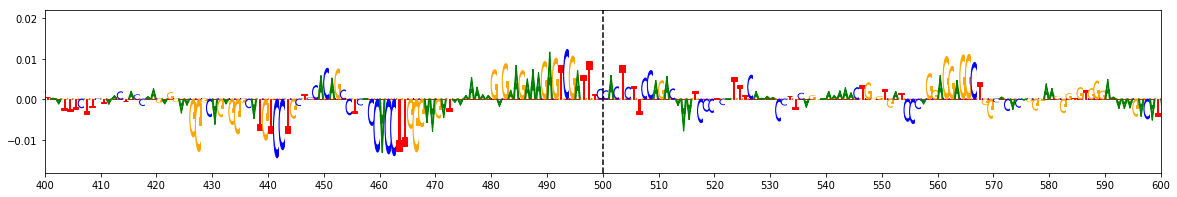

Allele Ratio : 1.4005   ||   Allele Difference : 0.0909  ||  ISM Score : 0.1427  ||  deltaSVM Score : 0.8162


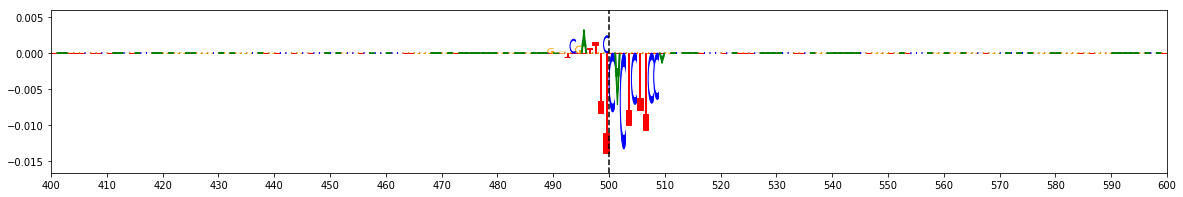


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 242   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.2784   ||  Center / 200bp: 0.3385
Effect Sequence: GCGGCTGCATTGGCCGGGGC


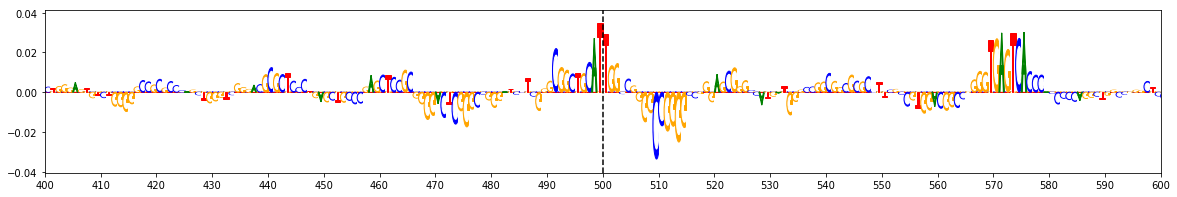

Noneffect Allele: G   ||  Explain Score: 0.1096   ||  Center / 200bp: 0.1685
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


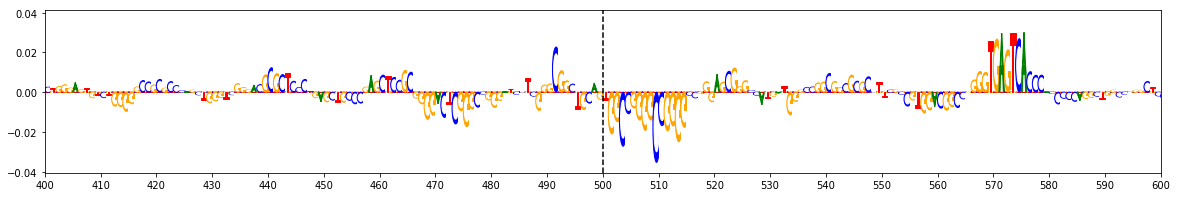

Allele Ratio : 2.5401   ||   Allele Difference : 0.2982  ||  ISM Score : 0.4705  ||  deltaSVM Score : 2.9802


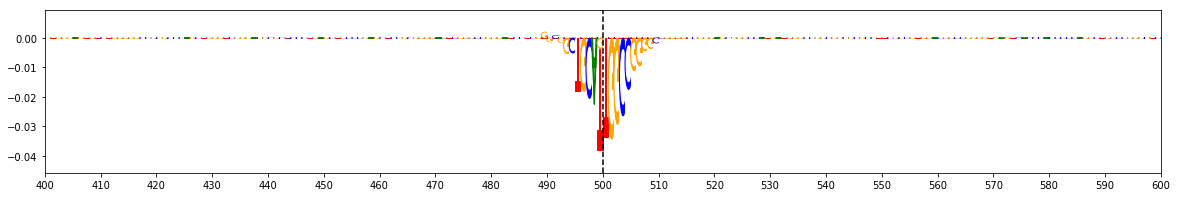


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2732651   ||    chr17 : 46267696 - 46267697   ||    Locus: 98   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  4.01E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6245   ||  Center / 200bp: 0.6806
Effect Sequence: TTTAAGCACTGTCAGCCCCA


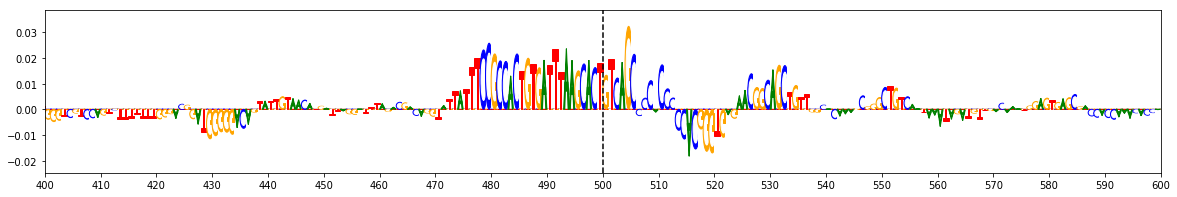

Noneffect Allele: C   ||  Explain Score: 0.5079   ||  Center / 200bp: 0.6341
Noneffect Sequence: TTTAAGCACCGTCAGCCCCA


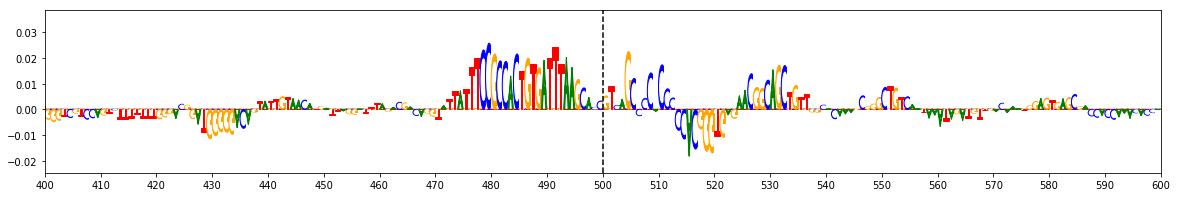

Allele Ratio : 1.2295   ||   Allele Difference : 0.1164  ||  ISM Score : 0.1831  ||  deltaSVM Score : 1.0256


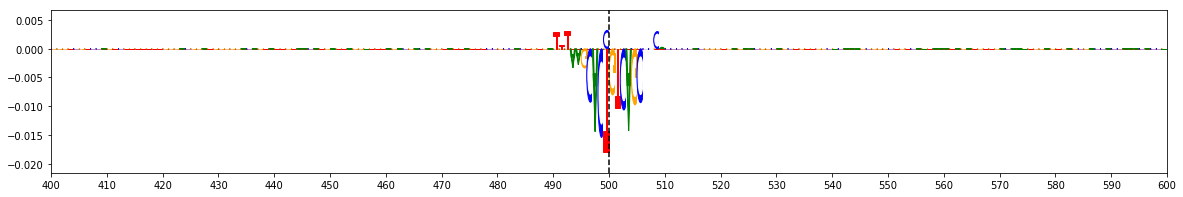


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79301522   ||    chr17 : 46130565 - 46130566   ||    Locus: 92   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.69E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.2101   ||  Center / 200bp: 0.3067
Effect Sequence: AACGAAAACGAAAACAAGAA


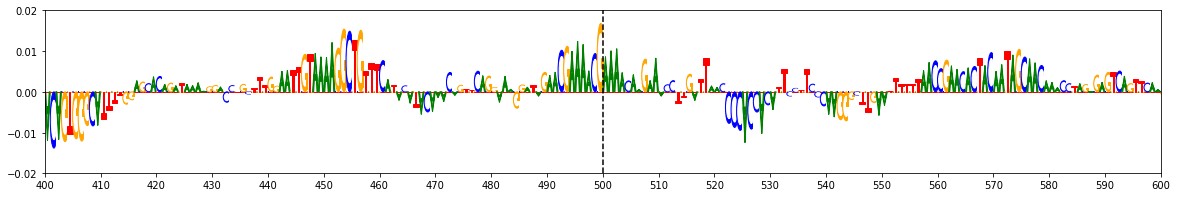

Noneffect Allele: A   ||  Explain Score: 0.0855   ||  Center / 200bp: 0.1524
Noneffect Sequence: AACGAAAACAAAAACAAGAA


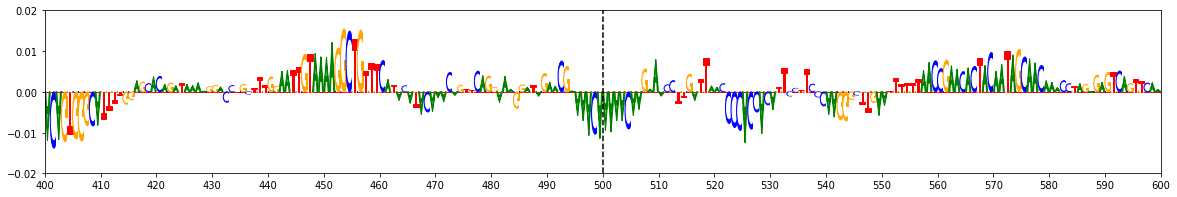

Allele Ratio : 2.4585   ||   Allele Difference : 0.2232  ||  ISM Score : 0.3434  ||  deltaSVM Score : 2.0087


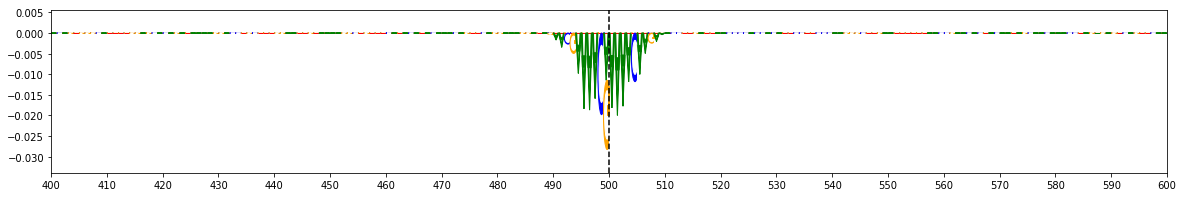


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11540084   ||    chr19 : 44644039 - 44644040   ||    Locus: 120   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  5.12E-08
Alzheimers_Jansen_2018 		  2.18E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.1452   ||  Center / 200bp: 0.7292
Effect Sequence: AGAGCGAGCTGGCGCCGGGA


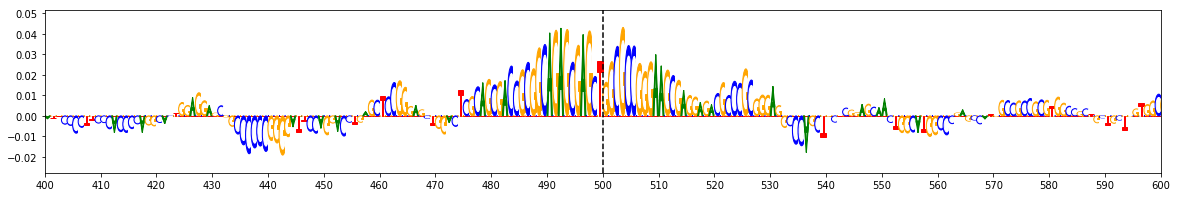

Noneffect Allele: G   ||  Explain Score: 1.1083   ||  Center / 200bp: 0.7231
Noneffect Sequence: AGAGCGAGCGGGCGCCGGGA


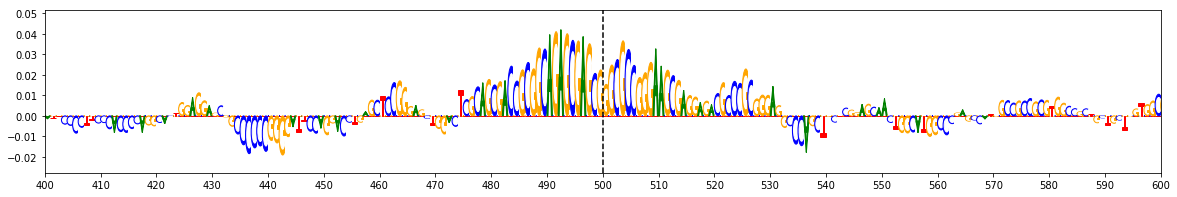

Allele Ratio : 1.0333   ||   Allele Difference : 0.0369  ||  ISM Score : 0.0565  ||  deltaSVM Score : 0.3123


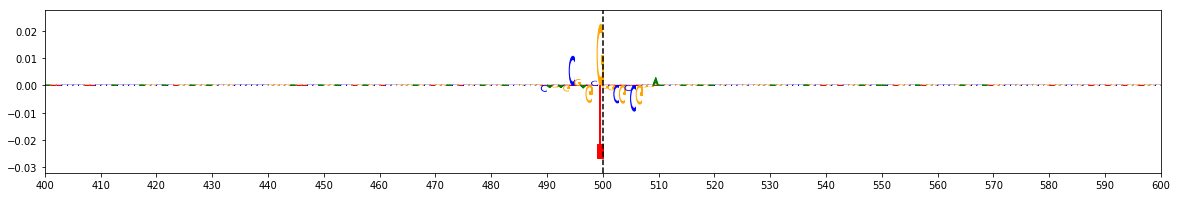


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171393   ||    chr2 : 134718389 - 134718390   ||    Locus: 179   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.02E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7625   ||  Center / 200bp: 0.4929
Effect Sequence: CGGAGTGGCGCAGAAGCGCT


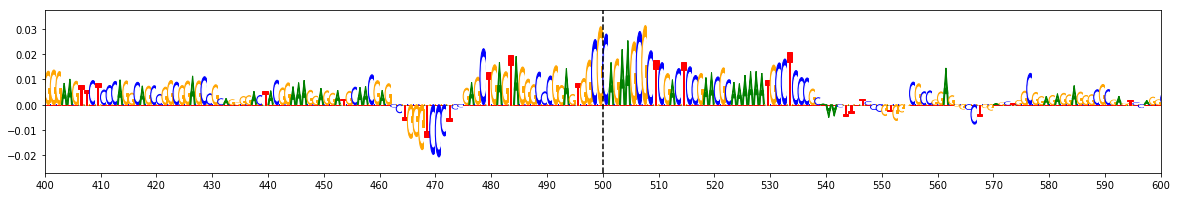

Noneffect Allele: C   ||  Explain Score: 0.5064   ||  Center / 200bp: 0.3923
Noneffect Sequence: CGGAGTGGCCCAGAAGCGCT


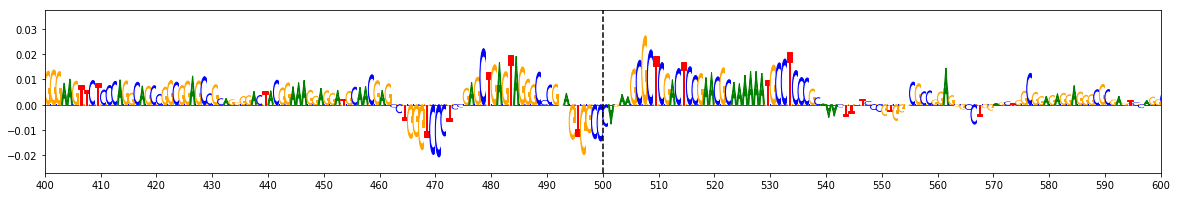

Allele Ratio : 1.5056   ||   Allele Difference : 0.3578  ||  ISM Score : 0.561  ||  deltaSVM Score : 3.2278


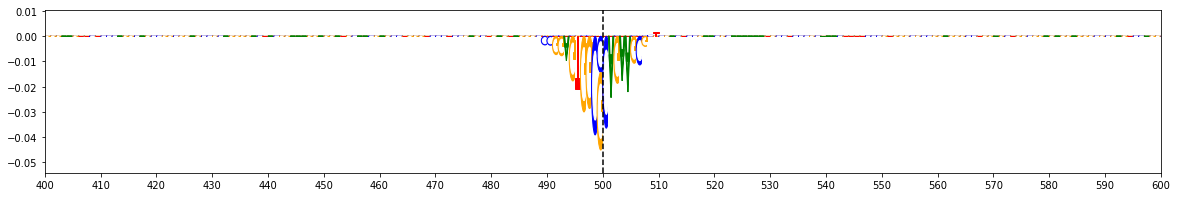


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34746918   ||    chr19 : 18428933 - 18428934   ||    Locus: 116   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.64E-02
Alzheimers_Kunkle_2019 		  1.97E-05
Alzheimers_Lambert_2013 	  3.05E-05

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.2893   ||  Center / 200bp: 0.292
Effect Sequence: CGACTCTGCTCCCATCCCTG


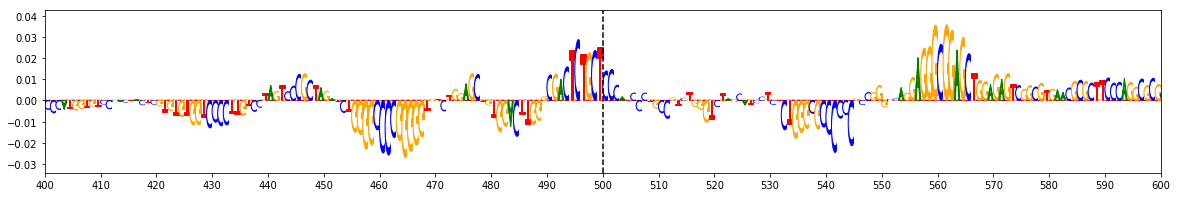

Noneffect Allele: C   ||  Explain Score: 0.1178   ||  Center / 200bp: 0.1439
Noneffect Sequence: CGACTCTGCCCCCATCCCTG


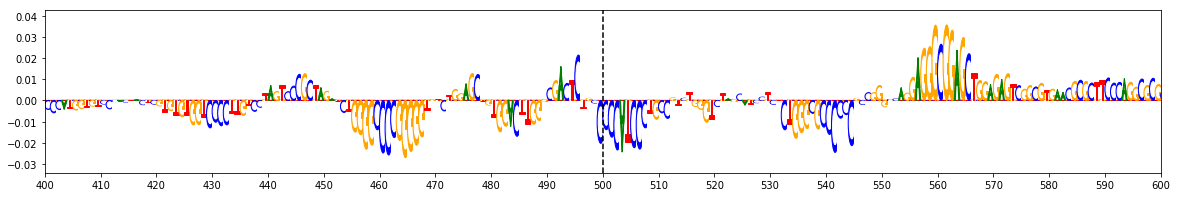

Allele Ratio : 2.4561   ||   Allele Difference : 0.3602  ||  ISM Score : 0.5694  ||  deltaSVM Score : 3.2621


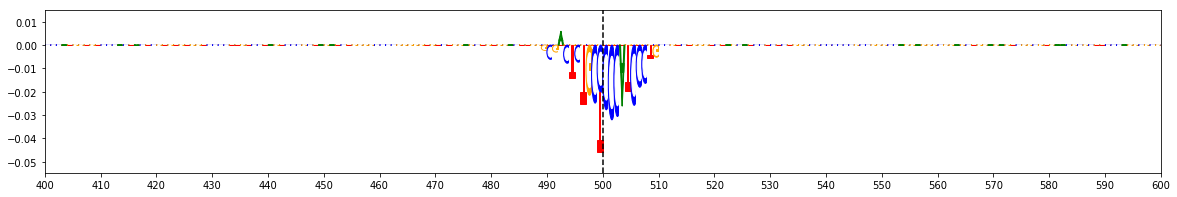


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 181   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4753   ||  Center / 200bp: 0.3904
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


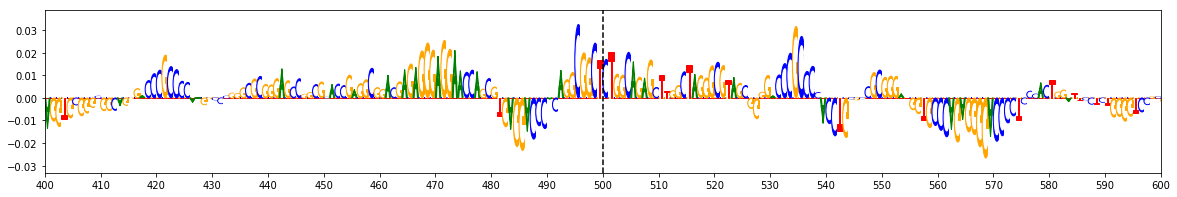

Noneffect Allele: C   ||  Explain Score: 0.2711   ||  Center / 200bp: 0.2666
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


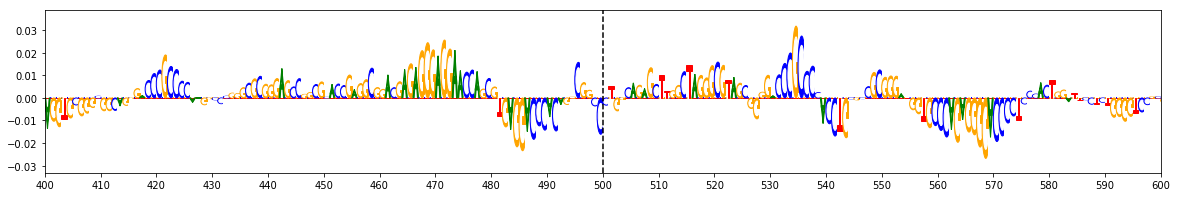

Allele Ratio : 1.7534   ||   Allele Difference : 0.2574  ||  ISM Score : 0.4122  ||  deltaSVM Score : 2.3723


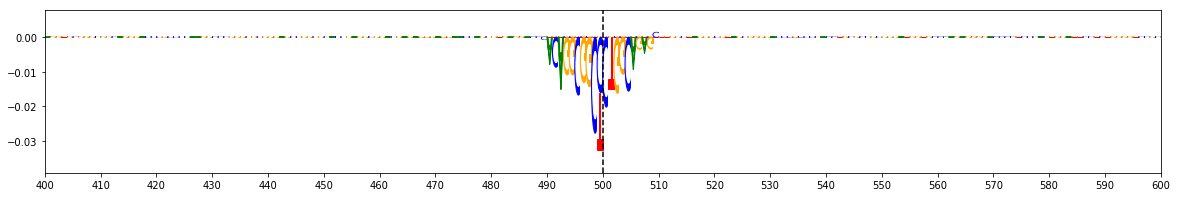


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs61481506   ||    chr17 : 5255418 - 5255419   ||    Locus: 59   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.49E-09

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.4594   ||  Center / 200bp: 0.4234
Effect Sequence: GACTAGGAACTGTGCCTTCA


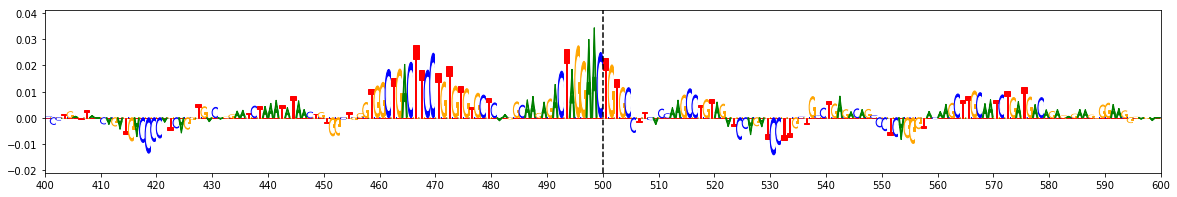

Noneffect Allele: T   ||  Explain Score: 0.2843   ||  Center / 200bp: 0.3122
Noneffect Sequence: GACTAGGAATTGTGCCTTCA


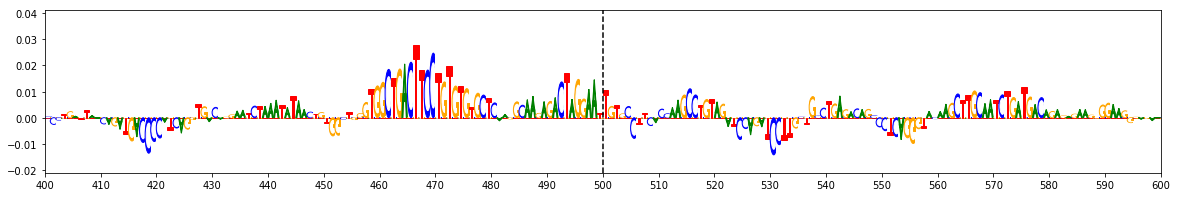

Allele Ratio : 1.6158   ||   Allele Difference : 0.1798  ||  ISM Score : 0.2811  ||  deltaSVM Score : 1.6222


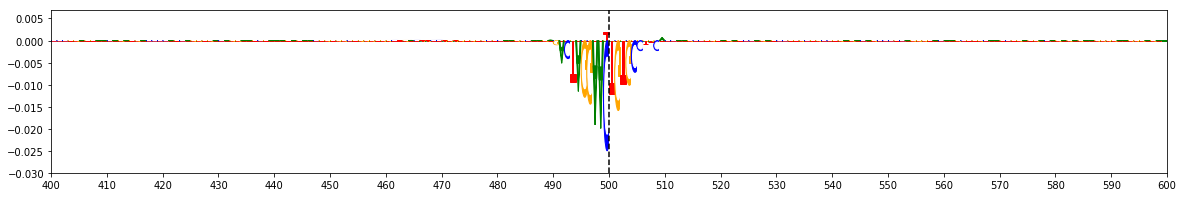


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs858295   ||    chr7 : 23205949 - 23205950   ||    Locus: 236   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  7.02E-06
Nalls_23andMe 		  7.02E-06

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9208   ||  Center / 200bp: 0.588
Effect Sequence: CCCGGCAGAGAGAGCTCGAA


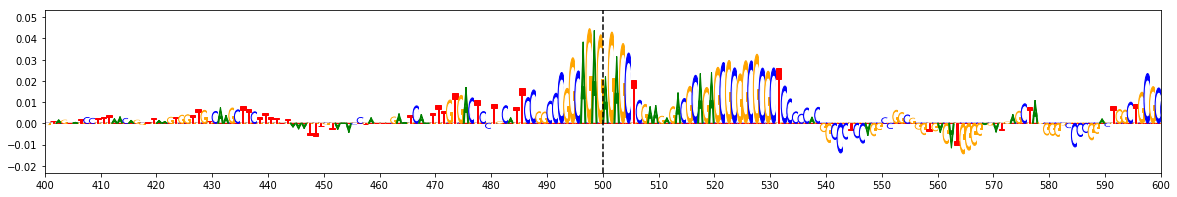

Noneffect Allele: A   ||  Explain Score: 0.812   ||  Center / 200bp: 0.5569
Noneffect Sequence: CCCGGCAGAAAGAGCTCGAA


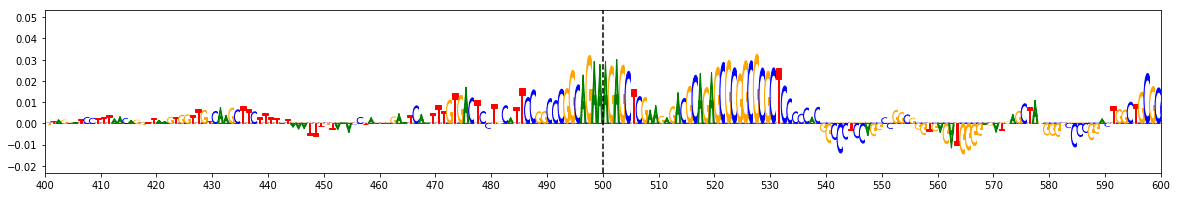

Allele Ratio : 1.134   ||   Allele Difference : 0.1089  ||  ISM Score : 0.1736  ||  deltaSVM Score : 0.9836


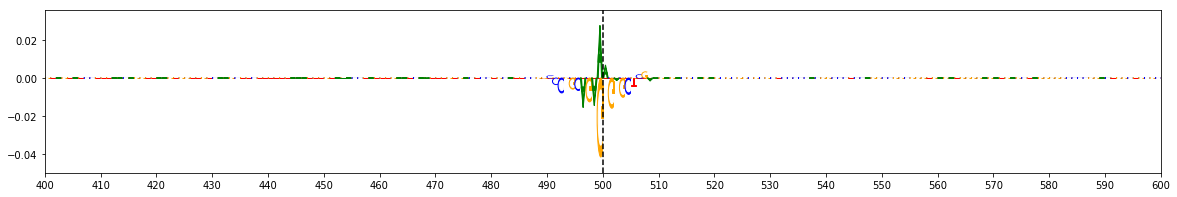


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs878320   ||    chr10 : 15515271 - 15515272   ||    Locus: 5   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  4.88E-04
Nalls_23andMe 		  4.88E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.3085   ||  Center / 200bp: 0.4836
Effect Sequence: AACTTCAGTGCTCATCCGTA


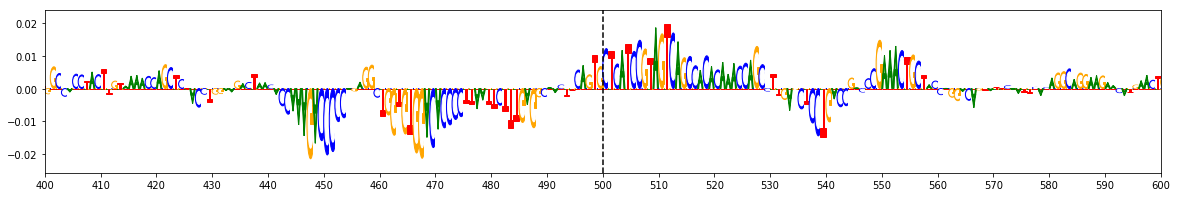

Noneffect Allele: C   ||  Explain Score: 0.2245   ||  Center / 200bp: 0.4052
Noneffect Sequence: AACTTCAGTCCTCATCCGTA


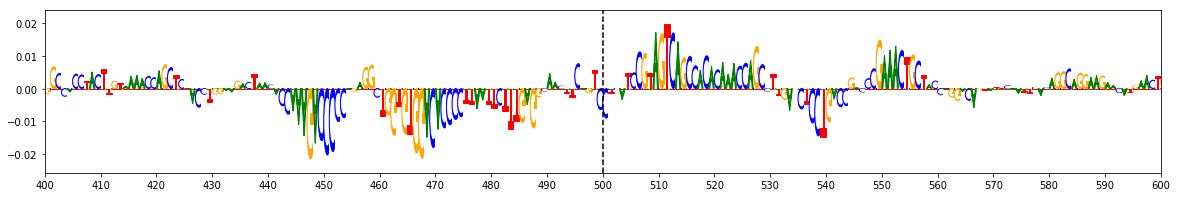

Allele Ratio : 1.374   ||   Allele Difference : 0.1044  ||  ISM Score : 0.163  ||  deltaSVM Score : 0.9193


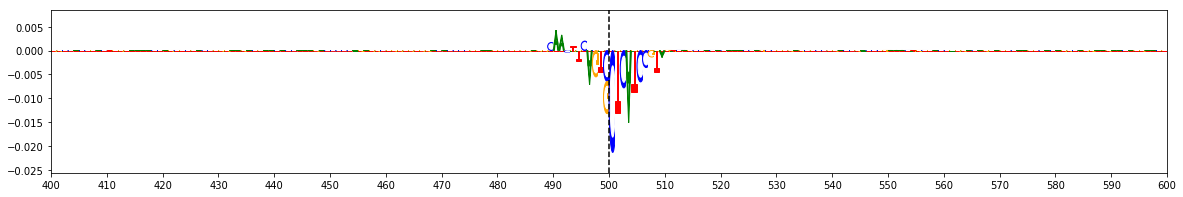


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72835016   ||    chr17 : 4842691 - 4842692   ||    Locus: 50   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  5.94E-04
Alzheimers_Lambert_2013 	  1.45E-04

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.7794   ||  Center / 200bp: 0.5695
Effect Sequence: CTCAGGAAACAGTCTTCAAG


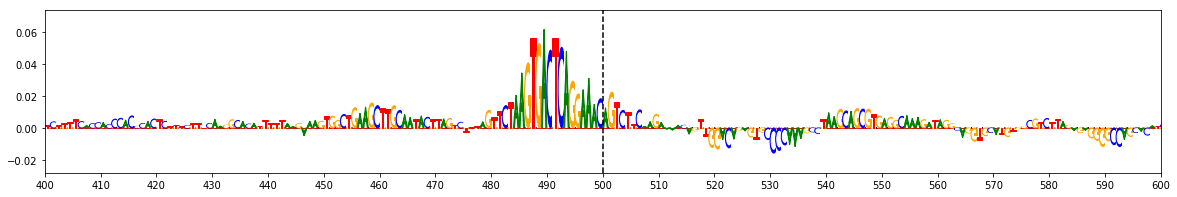

Noneffect Allele: G   ||  Explain Score: 0.6702   ||  Center / 200bp: 0.5321
Noneffect Sequence: CTCAGGAAAGAGTCTTCAAG


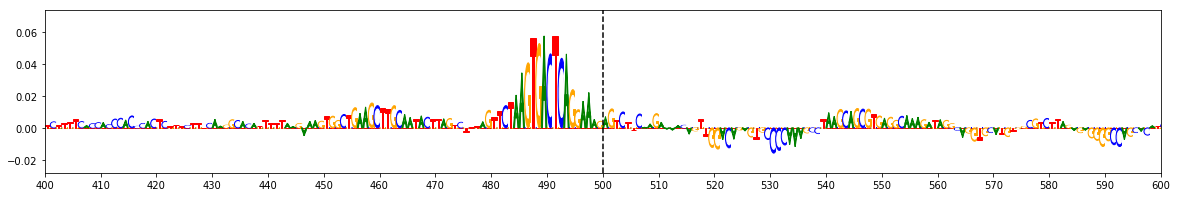

Allele Ratio : 1.163   ||   Allele Difference : 0.1108  ||  ISM Score : 0.1697  ||  deltaSVM Score : 1.004


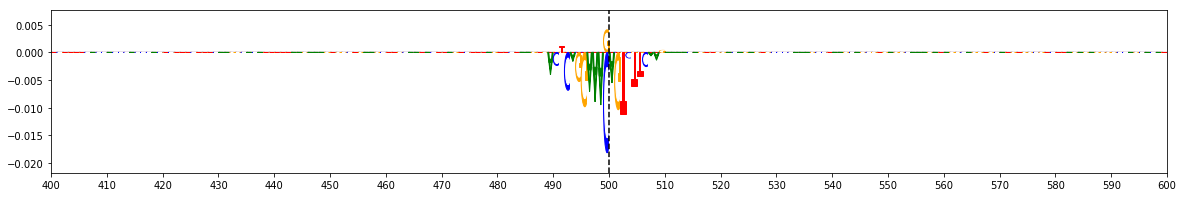


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 14   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9158   ||  Center / 200bp: 0.5288
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


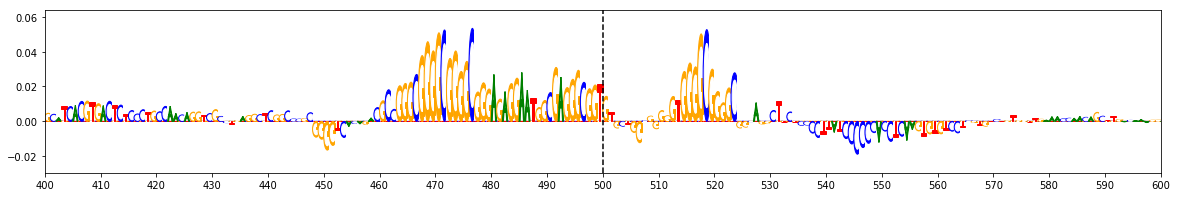

Noneffect Allele: C   ||  Explain Score: 0.7334   ||  Center / 200bp: 0.4737
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


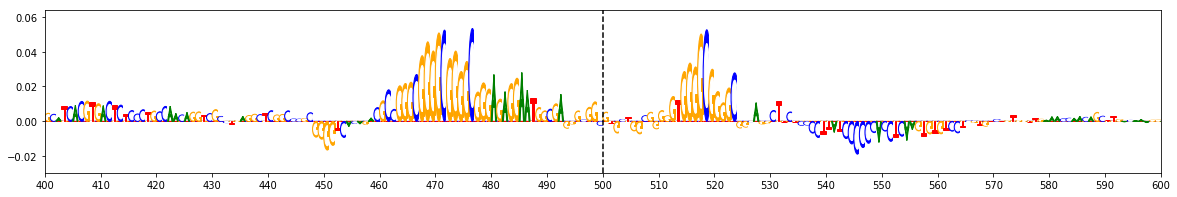

Allele Ratio : 1.2487   ||   Allele Difference : 0.184  ||  ISM Score : 0.3056  ||  deltaSVM Score : 1.8412


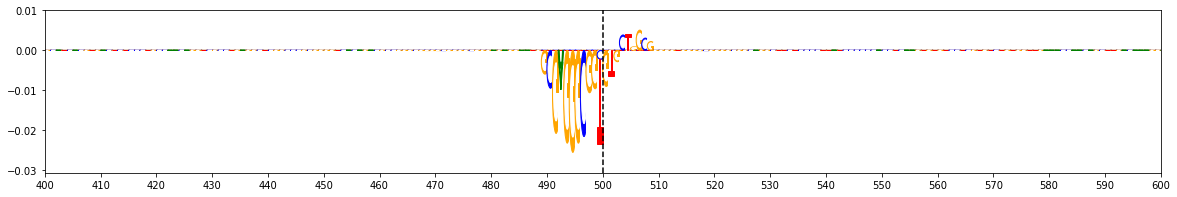


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3826419   ||    chr17 : 62065808 - 62065809   ||    Locus: 104   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.70E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4559   ||  Center / 200bp: 0.4174
Effect Sequence: TTCCTGGGCGAAGCCGGCCT


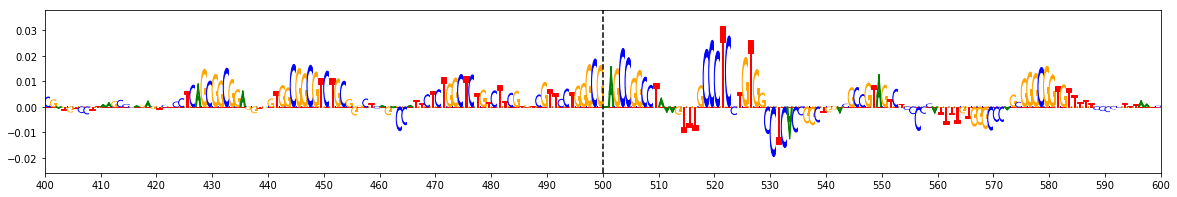

Noneffect Allele: C   ||  Explain Score: 0.2916   ||  Center / 200bp: 0.3147
Noneffect Sequence: TTCCTGGGCCAAGCCGGCCT


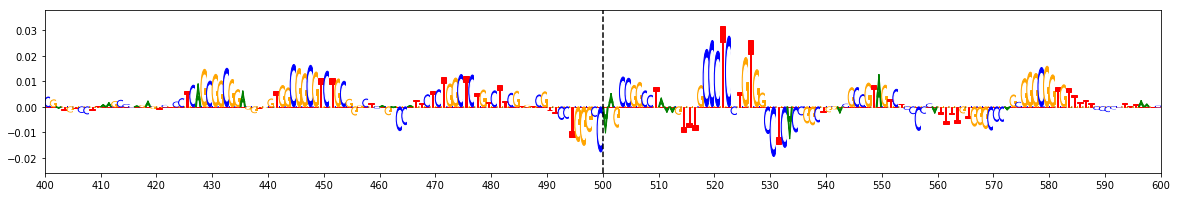

Allele Ratio : 1.5631   ||   Allele Difference : 0.2674  ||  ISM Score : 0.4192  ||  deltaSVM Score : 2.4258


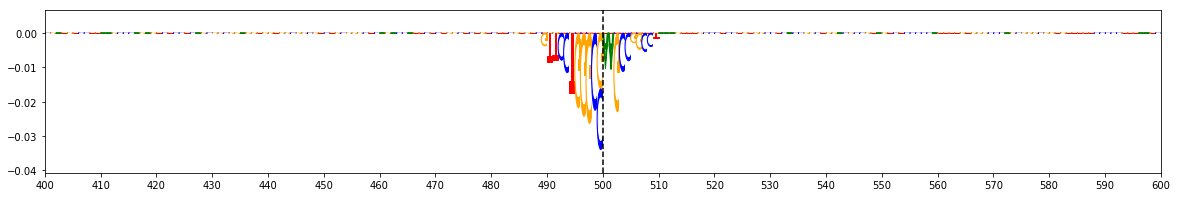


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6085343   ||    chr20 : 6006303 - 6006304   ||    Locus: 183   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.41E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9305   ||  Center / 200bp: 0.559
Effect Sequence: GCCGCTTGGGCTCCGGGAAC


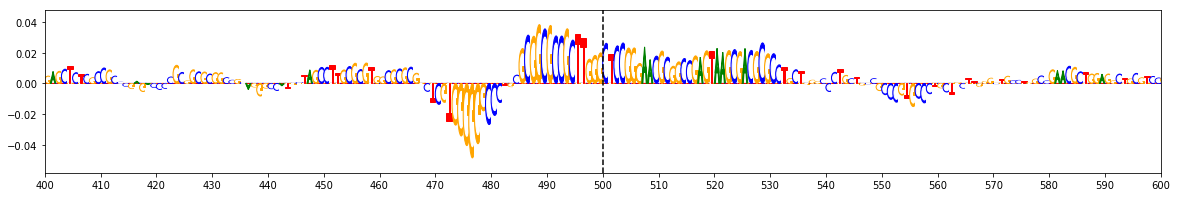

Noneffect Allele: A   ||  Explain Score: 0.8026   ||  Center / 200bp: 0.521
Noneffect Sequence: GCCGCTTGGACTCCGGGAAC


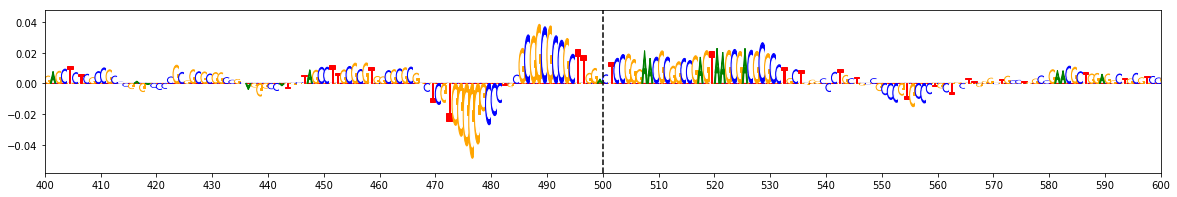

Allele Ratio : 1.1593   ||   Allele Difference : 0.129  ||  ISM Score : 0.2113  ||  deltaSVM Score : 1.2274


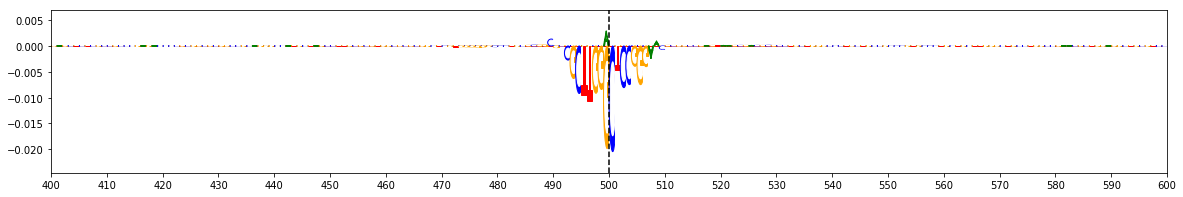


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs139549144   ||    chr12 : 40224911 - 40224912   ||    Locus: 23   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.38E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7217   ||  Center / 200bp: 0.4962
Effect Sequence: GGAGGAAGCGGAGCAGGAGG


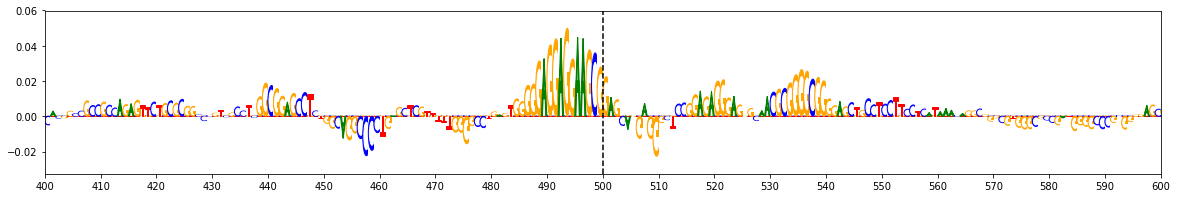

Noneffect Allele: C   ||  Explain Score: 0.5582   ||  Center / 200bp: 0.4316
Noneffect Sequence: GGAGGAAGCCGAGCAGGAGG


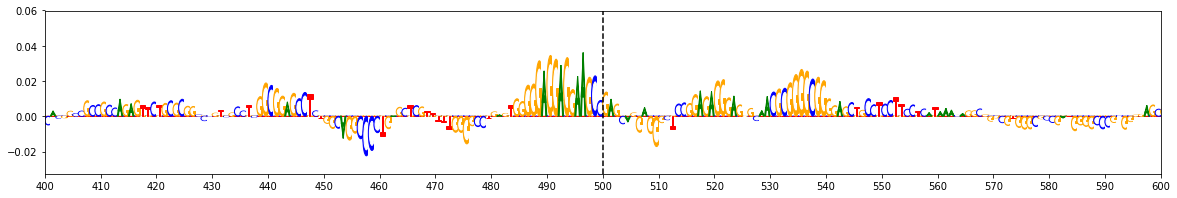

Allele Ratio : 1.2929   ||   Allele Difference : 0.1469  ||  ISM Score : 0.229  ||  deltaSVM Score : 1.3985


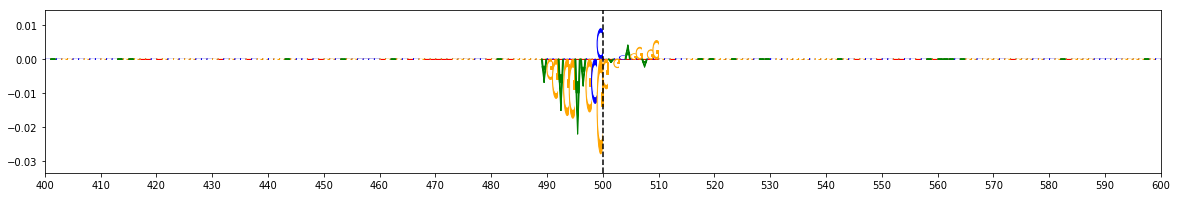


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()